# Importing libraries

In [103]:
#pip install plotly==5.0.0
#pip install xgboost
#pip install category-encoders
#pip install imblearn

In [104]:
import pandas as pd
import numpy as np
import statistics
import time
import sklearn

#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

import plotly.express as px

In [105]:
# Import packages for statistical testing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [106]:
# Import packages for model building
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor

In [107]:
import imblearn
#print(imblearn.__version__)

In [108]:
# Import packages for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

In [109]:
import pickle

In [110]:
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Join tables

In [111]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
campaign = pd.read_csv('./data/campaign_data.csv')
coupon = pd.read_csv('./data/coupon_item_mapping.csv')
demog = pd.read_csv('./data/customer_demographics.csv')
transaction = pd.read_csv('./data/customer_transaction_data.csv')
item = pd.read_csv('./data/item_data.csv')

#To update data and save them easily, a dictionary is created. 
# tables ={}
# tables['train'] = train
# tables['campaign'] = campaign
# tables['coupon'] = coupon 
# tables['demog'] = demog
# tables['transaction'] = transaction 
# tables['item'] = item

## Train table

In [112]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


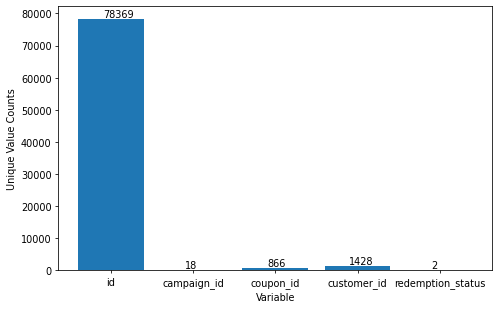

In [114]:
figure(figsize=(8, 5), dpi=70)
plt.bar(train.nunique().index,train.nunique())
plt.ylabel('Unique Value Counts')
plt.xlabel('Variable')
for i, v in enumerate(train.nunique()):
    plt.text(i-0.1, v+600, str(v))
plt.show()

In [115]:
train.duplicated().sum()

0

In [116]:
train[['campaign_id','coupon_id', 'customer_id']].duplicated().sum()

12

In [117]:
train[train[['campaign_id','coupon_id', 'customer_id']].duplicated(
    subset=None, keep=False)].sort_values('customer_id')

,id,campaign_id,coupon_id,customer_id,redemption_status
14850,24479,13,450,15,1
24627,40421,13,450,15,1
64294,105566,10,689,389,1
37669,61833,10,689,389,1
46146,75661,13,726,565,1
75782,124401,13,726,565,1
73994,121513,5,689,626,1
71759,117856,5,689,626,1
32378,53077,29,443,659,1
59747,98171,29,443,659,1


IDs are unique. They are almost a unqiue combination of campaign_id+coupon_id+customer_id. However, there are 12 duplicated values of such a combination, indicating perhaps some customers were accidentally counted twice? Especially since all duplicates also have same redemption_status value.

In [118]:
train.nunique()

id                   78369
campaign_id             18
coupon_id              866
customer_id           1428
redemption_status        2
dtype: int64

In [119]:
train.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [120]:
print('Overall redemption rate is: {:.2f}%'.format(len(train[train.redemption_status==1].index)/len(train)*100))

Overall redemption rate is: 0.93%


1. Train table has no duplicate, which means each combination of customer_id, coupon_id, and campaign_id is unique. However, not all customer_id+coupon_id combinations are unique (1268 duplicates), which means, the same coupon was used in more than one campaign.
2. Train table contains data from 18 campaigns and involves 866 unique coupons and 1428 unique customers.
3. The data is very imbalanced. Positive rate is only 0.93%.

## Campaign table

In [121]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [122]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [123]:
campaign.nunique()

campaign_id      28
campaign_type     2
start_date       25
end_date         26
dtype: int64

In [124]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [125]:
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format='%d/%m/%y') #better to specify format
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format='%d/%m/%y')

In [126]:
campaign["campaign_duration"] = (campaign['end_date']-campaign['start_date']).dt.days 
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,Y,2013-10-21,2013-12-20,60
1,25,Y,2013-10-21,2013-11-22,32
2,20,Y,2013-09-07,2013-11-16,70
3,23,Y,2013-10-08,2013-11-15,38
4,21,Y,2013-09-16,2013-10-18,32


In [127]:
campaign_chart = campaign[['campaign_id', 'start_date', 'end_date']]
campaign_chart['campaign'] = ["{} {}".format("Campaign",i) for i in campaign_chart['campaign_id']]
campaign_chart=campaign_chart.sort_values('campaign_id')

transaction['date'] = pd.to_datetime(transaction['date'], format='%Y-%m-%d') #better to specify format
trans_timeline = {'campaign_id':100, 'start_date':transaction['date'].min(), 
          'end_date':transaction['date'].max(),'campaign':'transaction period' }

campaign_chart = campaign_chart.append(trans_timeline,ignore_index=True)
fig = px.timeline(campaign_chart, x_start="start_date", x_end="end_date", y="campaign",
                 width=1000, height=600)
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [128]:
sorted(train.campaign_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30]

1. A total number of 28 campaigns have been conducted from September of 2012 to December of 2013.
2. 22 out of 28 campaigns are type Y; the rest are type X.
3. All campaigns overlap with at least one other campaign. There were no campaign 14 and 15. It is likely that these campaigns were conducted but the data was not made available. (Reason: if we look at the Ganchatt, there is no "break" except for July/August of 2013, which conincides with missing campaign 14 and 15.) Also, the earliest five campaigns have an id from 26-30. Otherwise, the campaign_id is consistent with the order of the campaigns based on start date.
4. Note: Train table contains campaigns 1-13 & 26-30, which occurred during 2012/8/12-2013/7/5. This period of time has no overlap with the campaigns in the test table, thus no data leakage issue!
- One thing we may be able to do to solve two issues (lack of test dataset labels and transaction data leakage) is to use data from campaigns 26-30 & 1-8 (2012/8/12-2013/4/5) to predict results for campaigns 10-13 (2013/4/8-2013/7/5)

In [129]:
# Positive labels for campaigns 26-30 & 1-8
potential_train_campaigns = [1, 2, 3, 4, 5, 6, 7, 8, 26, 27, 28, 29, 30]
train[train.campaign_id.map(
    lambda x: True if x in potential_train_campaigns else False)].redemption_status.value_counts()

0    45205
1      335
Name: redemption_status, dtype: int64

In [130]:
# Positive labels for campaigns 10-13
potential_test_campaigns = [10, 11, 12, 13]
train[train.campaign_id.map(
    lambda x: True if x in potential_test_campaigns else False)].redemption_status.value_counts()

0    29290
1      371
Name: redemption_status, dtype: int64

## Coupon table

In [131]:
coupon.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [132]:
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


1. How many types of coupon are in the design?
2. How many items does each coupon cover?
3. How frequent does each item show up in a coupon?

In [133]:
coupon.coupon_id.nunique()

1116

In [134]:
num_it_in_cp_df = \
    coupon.groupby('coupon_id')['item_id'].nunique().reset_index().rename(columns={'item_id':'num_it_in_cp'})
#reset_index() converts series to dataframe

In [135]:
num_it_in_cp_df.num_it_in_cp.value_counts()

4       74
3       72
2       67
1       64
5       59
        ..
92       1
93       1
101      1
107      1
3718     1
Name: num_it_in_cp, Length: 118, dtype: int64

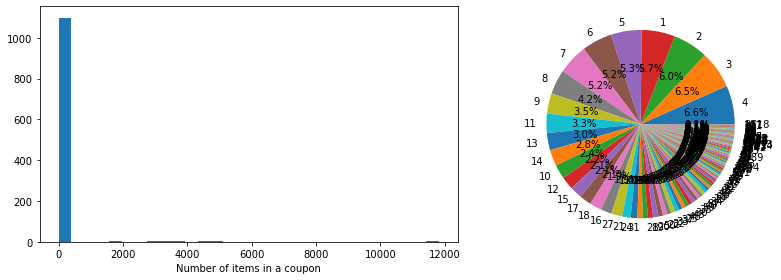

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(num_it_in_cp_df.num_it_in_cp, bins=30)
axes[0].set_xlabel('Number of items in a coupon')
axes[1].pie(num_it_in_cp_df.num_it_in_cp.value_counts(), 
            labels=num_it_in_cp_df.num_it_in_cp.value_counts().index, 
            autopct='%1.1f%%')
fig.tight_layout()

In [137]:
num_it_in_cp_df['num_it_in_cp_bin'] = pd.cut(x=num_it_in_cp_df['num_it_in_cp'], 
                                             bins=[0, 5, 10, 50, 100, 1000, 12000])
print(num_it_in_cp_df['num_it_in_cp_bin'].unique())
num_it_in_cp_df['num_it_in_cp_bin'].value_counts()

[(10, 50], (0, 5], (5, 10], (1000, 12000], (100, 1000], (50, 100]]
Categories (6, interval[int64]): [(0, 5] < (5, 10] < (10, 50] < (50, 100] < (100, 1000] < (1000, 12000]]


(10, 50]         433
(0, 5]           336
(5, 10]          229
(50, 100]         79
(100, 1000]       22
(1000, 12000]     17
Name: num_it_in_cp_bin, dtype: int64

In [138]:
coupon = pd.merge(coupon, num_it_in_cp_df, on='coupon_id', how='left') 
coupon.head()

,coupon_id,item_id,num_it_in_cp,num_it_in_cp_bin
0,105,37,17,"(10, 50]"
1,107,75,38,"(10, 50]"
2,494,76,35,"(10, 50]"
3,522,77,91,"(50, 100]"
4,518,77,70,"(50, 100]"


Flag: 'num_it_in_cp_bin' may need to be optimized

In [139]:
freq_it_in_cp_df = \
    coupon.groupby('item_id')['coupon_id'].nunique().reset_index().\
    rename(columns={'coupon_id':'freq_it_in_cp'})

freq_it_in_cp_df.freq_it_in_cp.value_counts()

3     12943
2     12936
1      5707
4      2807
5      1171
7       321
6       234
8        67
10       56
9        46
11        1
Name: freq_it_in_cp, dtype: int64

In [140]:
item.groupby('category').filter(lambda x:len(x)>6)

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery
...,...,...,...,...
74061,74062,5490,Established,Pharmaceutical
74062,74063,5497,Established,Pharmaceutical
74063,74064,5497,Established,Pharmaceutical
74064,74065,5520,Established,Pharmaceutical


Text(0, 0.5, 'Count')

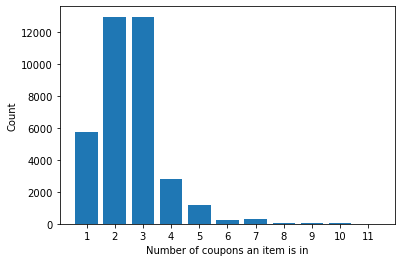

In [141]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.bar(freq_it_in_cp_df.freq_it_in_cp.value_counts().index,
         freq_it_in_cp_df.freq_it_in_cp.value_counts())

axes.set_xticks(freq_it_in_cp_df.freq_it_in_cp.value_counts().index)
axes.set_xlabel('Number of coupons an item is in')
axes.set_ylabel('Count')

In [142]:
coupon = pd.merge(coupon, freq_it_in_cp_df, on='item_id', how='left') 
coupon.head()

,coupon_id,item_id,num_it_in_cp,num_it_in_cp_bin,freq_it_in_cp
0,105,37,17,"(10, 50]",4
1,107,75,38,"(10, 50]",5
2,494,76,35,"(10, 50]",4
3,522,77,91,"(50, 100]",7
4,518,77,70,"(50, 100]",7


1. How many types of coupon are in the design? 
    - 1116
2. How many items does each coupon cover?
    - 118 possibilities, somewhere between 1 item to >1000 items.
    - Most coupons contain <50 items.
    - created two features in the coupon table: num_it_in_cp, num_it_in_cp_bin (may need to be optimized)
3. How frequent does each item show up in a coupon?
    - Most items are included in two or three coupons.
    - Created one feature in the coupon table: freq_it_in_cp

## Item table

In [143]:
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [144]:

item.groupby('category').get_group('Grocery').agg([np.sum, np.mean, np.std])



,item_id,brand,brand_type,category
sum,1.080893e+09,3.105385e+07,EstablishedLocalLocalLocalLocalLocalLocalEstab...,GroceryGroceryGroceryGroceryGroceryGroceryGroc...
mean,3.331154e+04,9.570343e+02,NaN,NaN
std,2.059392e+04,1.114908e+03,NaN,NaN


category
Alcohol                   AxesSubplot(0.125,0.125;0.775x0.755)
Bakery                    AxesSubplot(0.125,0.125;0.775x0.755)
Dairy, Juices & Snacks    AxesSubplot(0.125,0.125;0.775x0.755)
Flowers & Plants          AxesSubplot(0.125,0.125;0.775x0.755)
Fuel                      AxesSubplot(0.125,0.125;0.775x0.755)
Garden                    AxesSubplot(0.125,0.125;0.775x0.755)
Grocery                   AxesSubplot(0.125,0.125;0.775x0.755)
Meat                      AxesSubplot(0.125,0.125;0.775x0.755)
Miscellaneous             AxesSubplot(0.125,0.125;0.775x0.755)
Natural Products          AxesSubplot(0.125,0.125;0.775x0.755)
Packaged Meat             AxesSubplot(0.125,0.125;0.775x0.755)
Pharmaceutical            AxesSubplot(0.125,0.125;0.775x0.755)
Prepared Food             AxesSubplot(0.125,0.125;0.775x0.755)
Restauarant               AxesSubplot(0.125,0.125;0.775x0.755)
Salads                    AxesSubplot(0.125,0.125;0.775x0.755)
Seafood                   AxesSubplot(0.125,0.

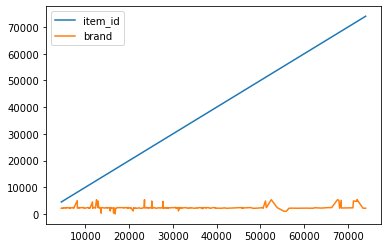

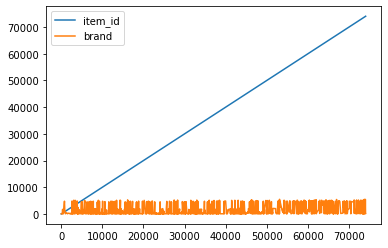

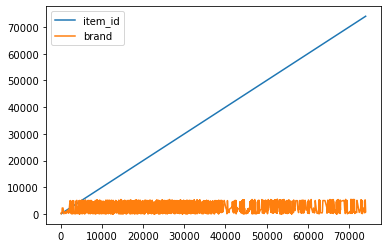

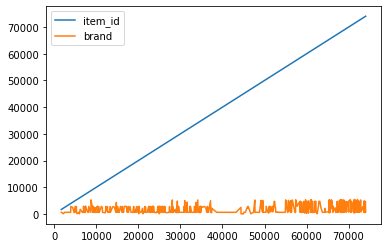

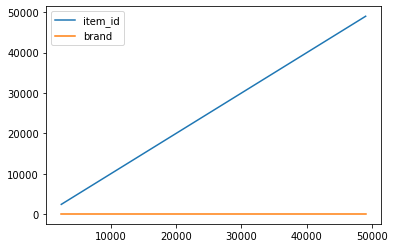

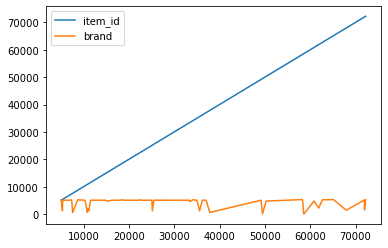

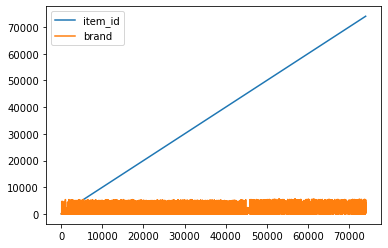

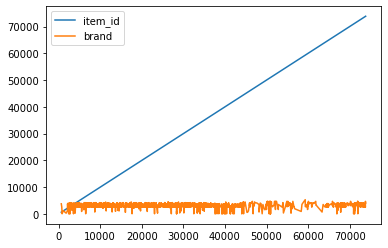

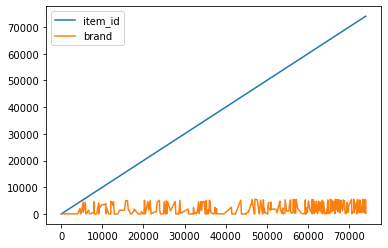

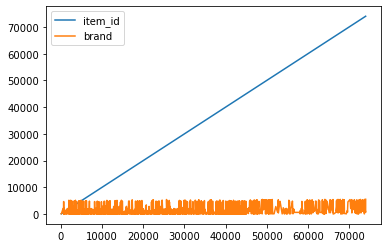

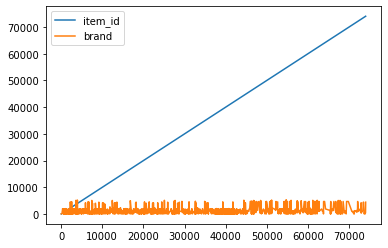

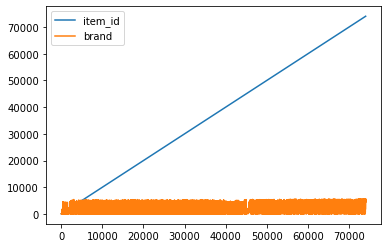

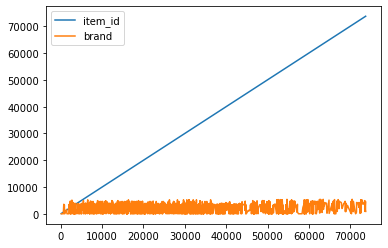

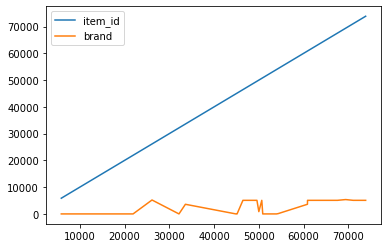

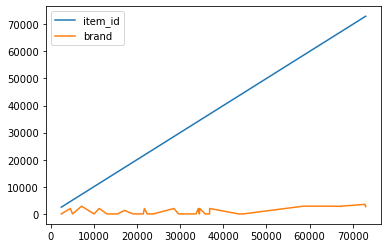

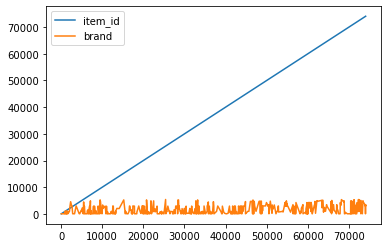

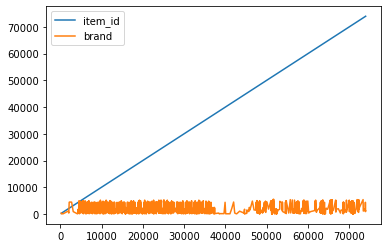

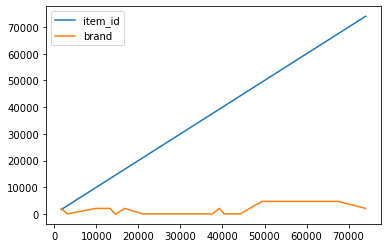

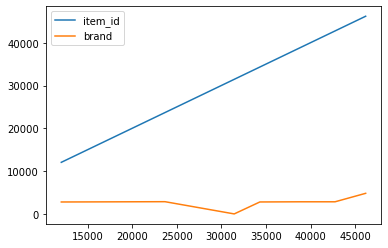

In [145]:
item.groupby('category').plot()

In [146]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [147]:
item.item_id.nunique()

74066

In [148]:
item.brand.value_counts()

56      10480
686      1142
1        1091
4700      923
1262      906
        ...  
4445        1
4573        1
2526        1
479         1
2047        1
Name: brand, Length: 5528, dtype: int64

In [149]:
num_it_in_brand_df = \
    item.groupby('brand')['item_id'].nunique().reset_index().rename(columns={'item_id':'num_it_in_brand'})
#reset_index() converts series to dataframe

In [150]:
num_it_in_brand_df.head()

,brand,num_it_in_brand
0,1,1091
1,2,1
2,3,1
3,4,33
4,5,3


In [151]:
num_it_in_brand_df['brand_bin'] = pd.cut(x=num_it_in_brand_df['num_it_in_brand'], 
                                             bins=[0, 10, 100, 11000])
print(num_it_in_brand_df['brand_bin'].unique())
num_it_in_brand_df['brand_bin'].value_counts()

[(100, 11000], (0, 10], (10, 100]]
Categories (3, interval[int64]): [(0, 10] < (10, 100] < (100, 11000]]


(0, 10]         4619
(10, 100]        804
(100, 11000]     105
Name: brand_bin, dtype: int64

Flag: brand_bin may need to be optimized

In [152]:
item = pd.merge(item, num_it_in_brand_df, on='brand', how='left') 
item.head()

,item_id,brand,brand_type,category,num_it_in_brand,brand_bin
0,1,1,Established,Grocery,1091,"(100, 11000]"
1,2,1,Established,Miscellaneous,1091,"(100, 11000]"
2,3,56,Local,Bakery,10480,"(100, 11000]"
3,4,56,Local,Grocery,10480,"(100, 11000]"
4,5,56,Local,Grocery,10480,"(100, 11000]"


1. How many brands are established brands?
2. How many items are from established brands?
3. How are items distributed in different categories?

In [153]:
item.groupby('brand_type')['brand', 'item_id'].nunique()

,brand,item_id
brand_type,,
Established,5509,62842
Local,19,11224


In [154]:
item.category.nunique()

19

In [155]:
item.groupby('category')['item_id'].nunique().sort_values(ascending=False)

category
Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: item_id, dtype: int64

1. How many brands are established brands?
    - 5509 brands are established, and only 19 brands are local.
2. How many items are from established brands?
    - 62842 items are from established brands, and 11224 items are from local brands.
3. How are items distributed in different categories?
    - There are 19 categories of items.

1. There are 74066 unique items on record, which belong to 5528 brands. 
    - some brands provide a broad set of items (some big bussinesses own a lot of product lines)
    - created two features in the item table: num_it_in_brand, brand_bin (may need to be optimized)
2. brand_type and category are categorical features that need to be engineered.

Questions that cannot be addressed using item table along:
1. How many brands does each coupon cover?
2. How many categories does each coupon cover? 

## Demographic table

In [156]:
demog.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [157]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [158]:
for i in demog.columns:
    print("{} has {:.3f}% missing values.".format(i, demog[i].isnull().sum()/len(demog[i])*100))

customer_id has 0.000% missing values.
age_range has 0.000% missing values.
marital_status has 43.289% missing values.
rented has 0.000% missing values.
family_size has 0.000% missing values.
no_of_children has 70.789% missing values.
income_bracket has 0.000% missing values.


In [159]:
demog.customer_id.nunique()

760

In [160]:
demog.age_range.value_counts()

46-55    271
36-45    187
26-35    130
70+       68
56-70     59
18-25     45
Name: age_range, dtype: int64

In [161]:
demog.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [162]:
demog.no_of_children.value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [163]:
demog.loc[demog[demog.marital_status.isnull()].index, ['marital_status']] = 'unknown'

In [164]:
demog.no_of_children.fillna('unknown', inplace = True)

In [165]:
demog.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,unknown,4
1,6,46-55,Married,0,2,unknown,5
2,7,26-35,unknown,0,3,1,3
3,8,26-35,unknown,0,4,2,6
4,10,46-55,Single,0,1,unknown,5


In [166]:
demog.rented.value_counts()

0    719
1     41
Name: rented, dtype: int64

In [167]:
demog.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [168]:
demog.income_bracket.value_counts()

5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
10     10
12     10
11      5
Name: income_bracket, dtype: int64

1. Demographic table has information for 760 unique customers (vs 1428 unique customers in train table, suggesting large missing information for our customers).
2. For the 760 customers on record, 43% of marital_status and 71% of no_of_children are missing.
    - New levels are created (unknown for both marital_status and children) to fill in the missing value.
2. All the features in the demographic table (age_range, marital_status, rented, no_of_children, family_size, income_bracket) are categorical features.
    - Some of the features may be converted to ordinal feature later on.

## Transaction table

In [169]:
transaction.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [170]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1324566 non-null  datetime64[ns]
 1   customer_id      1324566 non-null  int64         
 2   item_id          1324566 non-null  int64         
 3   quantity         1324566 non-null  int64         
 4   selling_price    1324566 non-null  float64       
 5   other_discount   1324566 non-null  float64       
 6   coupon_discount  1324566 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [171]:
transaction.customer_id.nunique()

1582

In [172]:
transaction.item_id.nunique()

74063

In [173]:
transaction.quantity.value_counts()

1        1054059
2         188907
3          33094
4          18745
5           5382
          ...   
11824          1
12851          1
13509          1
8753           1
6147           1
Name: quantity, Length: 9252, dtype: int64

In [174]:
(transaction.quantity==1).sum()/len(transaction)

0.7957768808802279

In [175]:
(transaction.quantity>100).sum()/len(transaction)

0.011752528752814129

In [176]:
# 20210705: assumed selling_price is sales

transaction.rename(columns={'selling_price': 'sales'}, inplace=True)

In [177]:
for i in ['sales', 'other_discount', 'coupon_discount']:
    print("{} has a range of [{}, {}]".format(i, transaction[i].min(), transaction[i].max())) 

sales has a range of [0.36, 17809.64]
other_discount has a range of [-3120.31, 0.0]
coupon_discount has a range of [-1992.23, 0.0]


In [178]:
# change discount values to positive
# can do df[col] = df[col].abs()
transaction['coupon_discount'] = transaction.coupon_discount.map(lambda x: -1*x if x<0 else 0)
transaction['other_discount'] = transaction.other_discount.map(lambda x: -1*x if x<0 else 0)

In [179]:
# fraction of transactions used other discount - about half 
len(transaction[transaction.other_discount > 0.0])/len(transaction)

0.507070995329791

In [180]:
# fraction of transactions used coupon discount - 1.6%, very small
len(transaction[transaction.coupon_discount  > 0.0])/len(transaction)

0.01607016939888235

In [181]:
transaction['use_other_discount'] = \
    transaction.other_discount.map(lambda x: 1 if x>0 else 0)

transaction['use_coupon_discount'] = \
    transaction.coupon_discount.map(lambda x: 1 if x>0 else 0)

transaction.head()

,date,customer_id,item_id,quantity,sales,other_discount,coupon_discount,use_other_discount,use_coupon_discount
0,2012-01-02,1501,26830,1,35.26,10.69,0.0,1,0
1,2012-01-02,1501,54253,1,53.43,13.89,0.0,1,0
2,2012-01-02,1501,31962,1,106.50,14.25,0.0,1,0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,0,0
4,2012-01-02,1501,48199,1,71.24,28.14,0.0,1,0


1. Who are the customers that purchase the most/least quantities?
2. Who are the customers that make the most/least expenditure (assuming selling_price is sales)?
3. Who are the customers that use the most/least other discount?
4. Who are the customers that use the most/least coupon discount?
5. What does each customer buy?

In [182]:
# For each customer (customer_id), count of total transactions

transaction_customer_ct = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['date'],
                       aggfunc=[len, lambda x: len(set(x))]
                      )

transaction_customer_ct.reset_index(inplace=True)

transaction_customer_ct = pd.DataFrame(transaction_customer_ct.iloc[:,:].values)
transaction_customer_ct.columns = ['customer_id','ct_trans','ct_trans_day']

transaction_customer_ct.head()

,customer_id,ct_trans,ct_trans_day
0,1,1048,56
1,2,419,37
2,3,705,41
3,4,220,26
4,5,792,163


In [183]:
# For each customer (customer_id), sum of total transactions
# 20210705: removed 'quantity'

transaction_customer_sum = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc=np.sum
                      )

new_cols = {'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'ct_use_other_discount',
            'use_coupon_discount':'ct_use_coupon_discount'}

transaction_customer_sum.reset_index(inplace=True)
transaction_customer_sum.rename(columns=new_cols, inplace = True)

transaction_customer_sum.head()

,customer_id,sum_coupon_discount,sum_other_discount,sum_sales,ct_use_coupon_discount,ct_use_other_discount
0,1,2116.83,17030.40,98513.93,78,497
1,2,249.34,7051.95,43100.03,4,179
2,3,2179.54,16013.53,73050.27,53,393
3,4,89.05,2927.19,33973.22,1,85
4,5,90.83,10817.07,103615.10,2,290


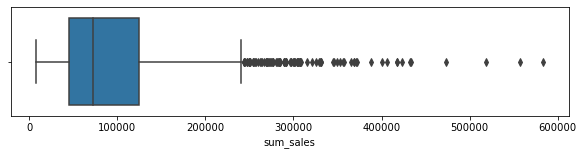

In [184]:
figure(figsize=(10, 2))
sns.boxplot(transaction_customer_sum.sum_sales, orient='h')
plt.show()

Text(0, 0.5, 'Total sales')

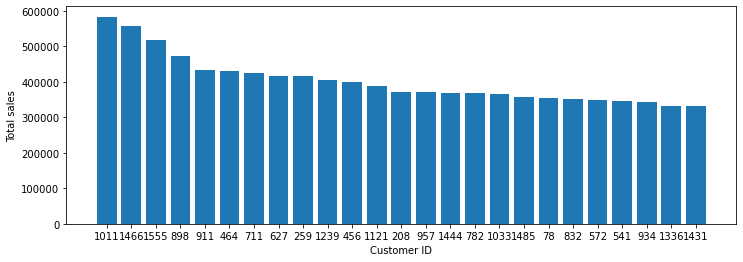

In [185]:
# example: Top customers with largest expenditures

top = 25

heavy_buyer = transaction_customer_sum.sort_values('sum_sales',ascending=False)[:top]

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(range(top),height=heavy_buyer.sum_sales)

axes.set_xticks(range(top))
axes.set_xticklabels(heavy_buyer.customer_id)
axes.set_xlabel('Customer ID')
axes.set_ylabel('Total sales')

In [186]:
# For each customer (customer_id), average per transaction
# 20210705: removed 'quantity'

transaction_customer_avg = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc= np.mean
                      )

new_cols = {'sales':'avg_sales',
            'other_discount':'avg_other_discount',
            'coupon_discount':'avg_coupon_discount',
            'use_other_discount':'avg_use_other_discount',
            'use_coupon_discount':'avg_use_coupon_discount'}

transaction_customer_avg.reset_index(inplace=True)
transaction_customer_avg.rename(columns=new_cols, inplace = True)

transaction_customer_avg.head()

,customer_id,avg_coupon_discount,avg_other_discount,avg_sales,avg_use_coupon_discount,avg_use_other_discount
0,1,2.019876,16.250382,94.001842,0.074427,0.474237
1,2,0.595084,16.830430,102.864033,0.009547,0.427208
2,3,3.091546,22.714227,103.617404,0.075177,0.557447
3,4,0.404773,13.305409,154.423727,0.004545,0.386364
4,5,0.114684,13.657917,130.827146,0.002525,0.366162


In [187]:
# For each customer (customer_id), would like to get the following information:
# monthly transactions, monthly purchase quantities, monthly spending, 
# monthly other discount, monthly coupon discount, monthly frequence of using other discount,
# monthly frequency of using coupon discount

In [188]:
# 20210705: removed 'quantity'

transaction_cus_date = pd.pivot_table(transaction, index=['customer_id','date'],
                                      values = ['item_id','sales','other_discount',
                                                'coupon_discount','use_other_discount','use_coupon_discount'],
                                      aggfunc = {'item_id': lambda x: len(x),
                                                 'sales': sum,
                                                 'other_discount': sum,
                                                 'coupon_discount': sum,
                                                 'use_other_discount': sum,
                                                 'use_coupon_discount': sum}
                                     )
                                      
new_cols = {'item_id': 'ct_trans',
            'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'ct_use_other_discount',
            'use_coupon_discount':'ct_use_coupon_discount'}

#transaction_cus_date.reset_index(inplace=True)
transaction_cus_date.rename(columns=new_cols, inplace = True)

transaction_cus_date.head()

sum_coupon_discount  ct_trans  sum_other_discount  \
customer_id date                                                            
1           2012-02-21                35.62        27              537.84   
            2012-03-08                 0.00        10              305.98   
            2012-03-29                 0.00         8              179.88   
            2012-04-04                17.81        19              331.27   
            2012-04-11                 0.00        14              546.41   

                        sum_sales  ct_use_coupon_discount  \
customer_id date                                            
1           2012-02-21    2603.45                       1   
            2012-03-08    1431.20                       0   
            2012-03-29     691.73                       0   
            2012-04-04    1913.50                       1   
            2012-04-11    1702.28                       0   

                        ct_use_other_discount  
customer_id date                               
1           2012-02-21                     14  
            2012-03-08                      5  
            2012-03-29                      5  
            2012-04-04                      9  
            2012-04-11                     11

In [189]:
customer_trans = pd.DataFrame()
customer_trans['customer_id'] = transaction.customer_id.unique()

# The two lines below made several features "object".
# for f in transaction_cus_date.columns:
#     customer_trans[f] = ''

for f in transaction_cus_date.columns:
    customer_trans[f] = np.nan

for i in customer_trans['customer_id']:
    
    # create the index with the start (the month of first purchase) and end time (2013-06-30)
    first_trans = transaction_cus_date.loc[i].index.min()
    t_index = pd.DatetimeIndex(pd.date_range(start=first_trans, end='2013-06-30', freq="1M"))

    # resample the data to 1 month, aggregate,
    # then reset the index and fill the na's with 0
    customer_trans.iloc[customer_trans[customer_trans['customer_id']==i].index, 1:] =\
        transaction_cus_date.loc[i].resample('M').sum().reindex(t_index).fillna(0).mean().values
            

new_cols = {'sum_coupon_discount':'monthly_cp_disc',
            'ct_trans':'monthly_ct_trans',
            'sum_other_discount':'monthly_other_disc',
            'sum_sales':'monthly_sales',
            'ct_use_coupon_discount':'monthly_freq_cp_disc',
            'ct_use_other_discount':'monthly_freq_other_disc'}

customer_trans.rename(columns=new_cols, inplace = True)      
customer_trans.head()

,customer_id,monthly_cp_disc,monthly_ct_trans,monthly_other_disc,monthly_sales,monthly_freq_cp_disc,monthly_freq_other_disc
0,1501,46.997778,19.944444,349.390000,2408.776667,1.722222,10.555556
1,857,66.094444,24.888889,411.246667,2605.804444,1.444444,12.222222
2,67,0.000000,24.611111,275.403889,1516.281667,0.000000,10.833333
3,751,0.593889,37.111111,746.013333,4987.387222,0.055556,19.888889
4,679,0.000000,76.000000,1263.567778,8731.938889,0.000000,42.111111


In [190]:
# What kind of products does each customer buy?

it_by_cus_df = \
    transaction.groupby('customer_id')['item_id'].unique().reset_index().rename(columns={'item_id':'it_by_cus'})
#reset_index() converts series to dataframe

it_by_cus_df['len_it_by_cus'] = it_by_cus_df.it_by_cus.map(len)

it_by_cus_df.head()

# Transaction table itself provides limited insights. Need to merge with item table. See later.

,customer_id,it_by_cus,len_it_by_cus
0,1,"[4953, 5626, 7808, 8107, 8307, 14054, 17047, 1...",463
1,2,"[31095, 45231, 45266, 45393, 45502, 7229, 1272...",352
2,3,"[10975, 13174, 14978, 16086, 16708, 18156, 195...",406
3,4,"[6121, 10461, 10594, 11816, 12433, 12838, 1324...",125
4,5,"[7745, 7787, 7798, 10347, 13467, 15633, 20070,...",490


1. What items were sold at the most/least quantities?
2. What items had the most/least sales?
3. What items had the most/least other discount?
4. What items had the most/least coupon discount?

In [191]:
# For each item (item_id), sum of total transactions

transaction_item_sum = pd.pivot_table(transaction, index = 'item_id',
                       values = ['quantity','sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc=np.sum
                      )

new_cols = {'quantity':'sum_quantity',
            'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'sum_use_other_discount',
            'use_coupon_discount':'sum_use_coupon_discount'}

transaction_item_sum.reset_index(inplace=True)
transaction_item_sum.rename(columns=new_cols, inplace = True)

transaction_item_sum.head()

,item_id,sum_coupon_discount,sum_other_discount,sum_quantity,sum_sales,sum_use_coupon_discount,sum_use_other_discount
0,1,0.0,0.0,2,248.62,0,0
1,2,0.0,0.0,1,35.26,0,0
2,3,0.0,0.0,1,56.64,0,0
3,4,0.0,0.0,1,54.85,0,0
4,5,0.0,0.0,1,81.57,0,0


Text(0, 0.5, 'Total sales')

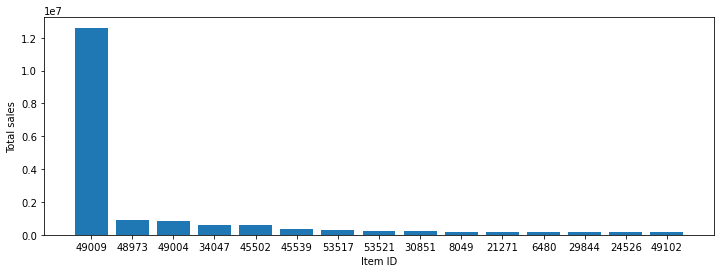

In [192]:
# example: Top sellers (items)

top = 15

top_seller = transaction_item_sum.sort_values('sum_sales',ascending=False)[:top]

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(range(top),height=top_seller.sum_sales)

axes.set_xticks(range(top))
axes.set_xticklabels(top_seller.item_id)
axes.set_xlabel('Item ID')
axes.set_ylabel('Total sales')

In [193]:
# Who bought item_id 49009? 919 customers bought it. 919 customers bought it. This item is popular.
transaction[transaction.item_id==49009].customer_id.nunique()

919

1. Transaction table has 1.3 millon records. 
    - 1582 unique customers vs. 1428 unique customers in train table vs. 760 unique customers in demographic table.
    - 74063 unique items vs. 74066 unique items in item table.
    - About 80% of the transactions are single item purchases. 1.2% of the transcations are bulk purchases (e.g., quantity > 100).
    - Heavy buyers identified (transaction_customer_sum).
    - Popluar items identified (transaction_item_sum).
2. Created two new binary features for transaction table: use_other_discount, use_coupon_discount
3. Three new dataframes to gain insights of customer purchase behavior (customer_id as primary key):
    - transaction_customer_avg (transaction data averaged by each transaction)
    - customer_trans (transaction data aggregated monthly)

## Merging tables

### Merging campaign table with train table

It is useful to see more of the campaign information aside from start/end time and type of campaign. For example, we may be interested in the following questions:
1. How many coupons (unique coupon_id) were issued in each campaign?
2. How many customers did each campaign send coupons to?
3. Following the question above, how many of these customers redeemed coupons? This needs further definition because each customer may deem more then one coupon in one campaign or deem different number of coupons in different campaigns. I think we don't need to dig deep here because later we will examine the relationship between features and redemption_status (target variable). 

Among all the tables provided, campaign_id only shows up in the train table and the campaign table. Therefore, we have to rely on the train table to derive more insights related to campaign information.

Text(0, 0.5, 'Number of coupons')

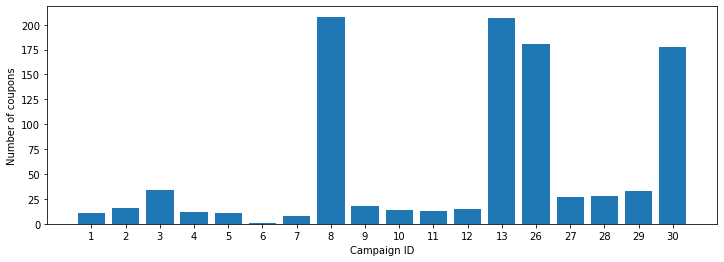

In [194]:
# How many coupons (unique coupon_id) are issued in each campaign
cp_in_camp_df = \
    train.groupby('campaign_id')['coupon_id'].nunique().reset_index().\
    rename(columns={'coupon_id':'cp_in_camp'})

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(cp_in_camp_df.index, cp_in_camp_df.cp_in_camp)

axes.set_xticks(cp_in_camp_df.index)
axes.set_xticklabels(cp_in_camp_df.campaign_id)
axes.set_xlabel('Campaign ID')
axes.set_ylabel('Number of coupons')

In [195]:
cp_in_camp_df.head()

,campaign_id,cp_in_camp
0,1,11
1,2,16
2,3,34
3,4,12
4,5,11


Text(0, 0.5, 'Number of customers')

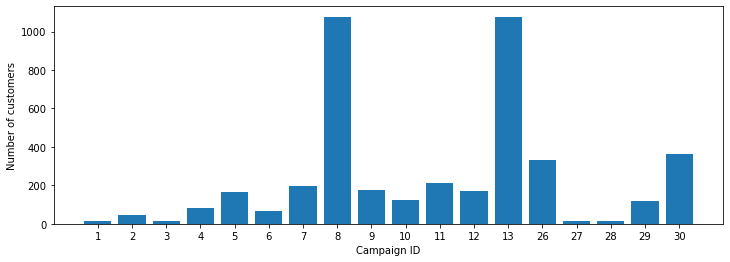

In [196]:
# How many customers has each campaign sent coupons to
cus_in_camp_df = \
    train.groupby('campaign_id')['customer_id'].nunique().reset_index().\
    rename(columns={'customer_id':'cus_in_camp'})

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(cus_in_camp_df.index, cus_in_camp_df.cus_in_camp)

axes.set_xticks(cus_in_camp_df.index)
axes.set_xticklabels(cus_in_camp_df.campaign_id)
axes.set_xlabel('Campaign ID')
axes.set_ylabel('Number of customers')

In [197]:
cus_in_camp_df.head()

,campaign_id,cus_in_camp
0,1,13
1,2,48
2,3,12
3,4,81
4,5,166


In [198]:
#train_raw = pd.merge(train, cp_in_camp_df, on='campaign_id', how='left') 
# cp_in_camp_df is not useful for model building because we do not know how many coupons will be sent in campaign

In [199]:
#train_raw = pd.merge(train_raw, cus_in_camp_df, on='campaign_id', how='left') 
# cus_in_camp_df is not useful for model building

In [200]:
#train_raw = pd.merge(train_raw, campaign, on='campaign_id', how='left') 

In [201]:
#train_raw.head()

### Merging coupon table & item table with train table

There are challenges for both coupon table and item table to merge with train table. 
- For coupon table, aggregation needs to be performed on coupon_id so that the conpon_id column has unique values.
- For item table, it cannot merge with train table because item_id doesn't exist in train table. Instead, the information in item table needs to be relayed through coupon table.

Create a dataframe that can address the following questions:
1. How many items are in each coupon (num_it_in_cp, num_it_in_cp_bin)?
2. How many brands does each coupon cover?
    - Mode of brand? (error: module 'statistics' has no attribute 'multimode')
    - Instead of mode, can try to create categorical features, follow by proper encoding (too many levels, dummy won't work)
3. How many categories does each coupon cover? 
    - Mode of category? 
4. How many brand types does each coupon cover?
    - Mode of brand_type?

In [202]:
coupon_item = pd.merge(coupon, item, on='item_id', how='left')
coupon_item.drop(columns='num_it_in_cp', inplace=True)
coupon_item.head()

,coupon_id,item_id,num_it_in_cp_bin,freq_it_in_cp,brand,brand_type,category,num_it_in_brand,brand_bin
0,105,37,"(10, 50]",4,56,Local,Grocery,10480,"(100, 11000]"
1,107,75,"(10, 50]",5,56,Local,Grocery,10480,"(100, 11000]"
2,494,76,"(10, 50]",4,209,Established,Grocery,295,"(100, 11000]"
3,522,77,"(50, 100]",7,278,Established,Grocery,547,"(100, 11000]"
4,518,77,"(50, 100]",7,278,Established,Grocery,547,"(100, 11000]"


In [203]:
coupon_item = coupon_item.iloc[:,:-2]

In [204]:
coupon_item = coupon_item.drop(columns=['freq_it_in_cp'])

In [205]:
coupon_item.head()

,coupon_id,item_id,num_it_in_cp_bin,brand,brand_type,category
0,105,37,"(10, 50]",56,Local,Grocery
1,107,75,"(10, 50]",56,Local,Grocery
2,494,76,"(10, 50]",209,Established,Grocery
3,522,77,"(50, 100]",278,Established,Grocery
4,518,77,"(50, 100]",278,Established,Grocery


In [206]:
coupon_id_df = pd.pivot_table(coupon_item, index = 'coupon_id',
                       values = ['brand', 'brand_type','category'],
                       aggfunc= lambda x: len(set(x))
                      )

new_cols = {'brand':'ct_brand',
            'brand_type': 'ct_brand_type',
            'category':'ct_category'}

coupon_id_df.reset_index(inplace=True)
coupon_id_df.rename(columns=new_cols, inplace = True)

coupon_id_df.head()

,coupon_id,ct_brand,ct_brand_type,ct_category
0,1,3,1,2
1,2,1,1,1
2,3,2,1,1
3,4,1,1,1
4,5,1,1,1


In [207]:
coupon_id_df.ct_brand.value_counts()

1       974
2        93
3        27
5         3
80        2
224       1
1185      1
955       1
521       1
520       1
390       1
383       1
371       1
170       1
216       1
128       1
126       1
59        1
15        1
6         1
4         1
1187      1
Name: ct_brand, dtype: int64

Most coupons (87%) contain just 1 brand. A few coupons contain a large number of brands. Here I transformed ct_brand to a flag feature where 0 - one brand, 1 - two brands and more.

In [208]:
coupon_id_df.loc[coupon_id_df[coupon_id_df.ct_brand==1].index,\
                 ['ct_brand']] = 0
coupon_id_df.loc[coupon_id_df[coupon_id_df.ct_brand>1].index,\
                 ['ct_brand']] = 1

Since most coupons contain one brand, we can find which brand it contains. For the other 13% of the coupons that contain more than one brand, it's technically possible to identify the mode, whether single mode or multi-mode. However, it is unclear if this effort will add value. Instead, I assigned "multiple" to coupons containing more than one brand.   

In [209]:
coupon_id_df = coupon_id_df.assign(brand=
    coupon_item.groupby('coupon_id')['brand'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_id_df.head()

,coupon_id,ct_brand,ct_brand_type,ct_category,brand
0,1,1,1,2,multiple
1,2,0,1,1,2084
2,3,1,1,1,multiple
3,4,0,1,1,544
4,5,0,1,1,5357


In [212]:
coupon_id_df

,coupon_id,ct_brand,ct_brand_type,ct_category,brand
0,1,1,1,2,multiple
1,2,0,1,1,2084
2,3,1,1,1,multiple
3,4,0,1,1,544
4,5,0,1,1,5357
...,...,...,...,...,...
1111,1112,0,1,1,5177
1112,1113,0,1,1,5184
1113,1114,0,1,1,2416
1114,1115,0,1,1,2446


In [105]:
coupon_id_df.ct_category.value_counts()

1     1065
2       35
7        5
6        3
3        2
5        2
15       2
8        1
14       1
Name: ct_category, dtype: int64

Most coupons (95%) contain just 1 category. Similar to how ct_brand was handled, I transformed ct_category to a flag feature where 0 - one category, 1 - two categories and more. Also, I assigned "multiple" to coupons containing more than one category.

In [106]:
coupon_id_df.loc[coupon_id_df[coupon_id_df.ct_category==1].index,\
                 ['ct_category']] = 0
coupon_id_df.loc[coupon_id_df[coupon_id_df.ct_category>1].index,\
                 ['ct_category']] = 1

coupon_id_df = coupon_id_df.assign(category=
    coupon_item.groupby('coupon_id')['category'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_id_df.head()

,coupon_id,ct_brand,ct_brand_type,ct_category,brand,category
0,1,1,1,1,multiple,multiple
1,2,0,1,0,2084,Grocery
2,3,1,1,0,multiple,Grocery
3,4,0,1,0,544,Grocery
4,5,0,1,0,5357,Pharmaceutical


In [107]:
coupon_id_df.ct_brand_type.value_counts()

1    1091
2      25
Name: ct_brand_type, dtype: int64

Most coupons (98%) contain just 1 brand_type. The process of creating new brand_type feature is similar to brand and category, except that ct_brand_type is dropped.

In [108]:
coupon_id_df.drop(columns='ct_brand_type', inplace=True)


coupon_id_df = coupon_id_df.assign(brand_type=
    coupon_item.groupby('coupon_id')['brand_type'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_id_df.head()

,coupon_id,ct_brand,ct_category,brand,category,brand_type
0,1,1,1,multiple,multiple,Established
1,2,0,0,2084,Grocery,Established
2,3,1,0,multiple,Grocery,Established
3,4,0,0,544,Grocery,Established
4,5,0,0,5357,Pharmaceutical,Established


In [109]:
# Add num_it_in_cp_bin from coupon table

coupon_id_df = coupon_id_df.assign(num_it_in_cp_bin=
    coupon_item.groupby('coupon_id')['num_it_in_cp_bin'].unique().map(lambda x:
                                                                  x[0]).values)

coupon_id_df.head()

,coupon_id,ct_brand,ct_category,brand,category,brand_type,num_it_in_cp_bin
0,1,1,1,multiple,multiple,Established,"(10, 50]"
1,2,0,0,2084,Grocery,Established,"(0, 5]"
2,3,1,0,multiple,Grocery,Established,"(10, 50]"
3,4,0,0,544,Grocery,Established,"(10, 50]"
4,5,0,0,5357,Pharmaceutical,Established,"(5, 10]"


In [110]:
# train_raw = pd.merge(train_raw, coupon_id_df, on='coupon_id', how='left')

# train_raw.head()

### Merging demographic table with train table

In [111]:
demog.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,unknown,4
1,6,46-55,Married,0,2,unknown,5
2,7,26-35,unknown,0,3,1,3
3,8,26-35,unknown,0,4,2,6
4,10,46-55,Single,0,1,unknown,5


In [112]:
#train_raw = pd.merge(train_raw, demog, on='customer_id', how='left')

#train_raw.head()

### Utilizing information from transaction table

**Dive deeper into customer purchase behavior**

In [113]:
transaction_item = pd.merge(transaction, item, on='item_id', how='left')
transaction_item.head()

,date,customer_id,item_id,quantity,sales,other_discount,coupon_discount,use_other_discount,use_coupon_discount,brand,brand_type,category,num_it_in_brand,brand_bin
0,2012-01-02,1501,26830,1,35.26,10.69,0.0,1,0,56,Local,Natural Products,10480,"(100, 11000]"
1,2012-01-02,1501,54253,1,53.43,13.89,0.0,1,0,56,Local,Natural Products,10480,"(100, 11000]"
2,2012-01-02,1501,31962,1,106.50,14.25,0.0,1,0,524,Established,Grocery,171,"(100, 11000]"
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,0,0,1134,Established,Grocery,296,"(100, 11000]"
4,2012-01-02,1501,48199,1,71.24,28.14,0.0,1,0,524,Established,Grocery,171,"(100, 11000]"


In [114]:
customer_item = pd.DataFrame()
customer_item['customer_id'] = transaction_item['customer_id'].unique()

In [115]:
customer_brand_type_df =\
    transaction_item.groupby('customer_id')['brand_type'].value_counts().unstack()

customer_brand_type_df =\
customer_brand_type_df.div(customer_brand_type_df.sum(axis=1), axis=0)

customer_brand_type_df.reset_index(inplace=True)

customer_item = pd.merge(customer_item, customer_brand_type_df, on='customer_id', how='left')
customer_item.drop(columns=['Local'],axis=1,inplace=True)
customer_item.head()

,customer_id,Established
0,1501,0.834711
1,857,0.834395
2,67,0.620767
3,751,0.736527
4,679,0.902047


In [116]:
customer_category_df =\
    transaction_item.groupby('customer_id')['category'].value_counts().unstack()

customer_category_df =\
customer_category_df.div(customer_category_df.sum(axis=1), axis=0)

customer_category_df.reset_index(inplace=True)

customer_item = pd.merge(customer_item, customer_category_df, on='customer_id', how='left')

customer_item.fillna(0, inplace=True)

customer_item.head()

,customer_id,Established,Alcohol,Bakery,"Dairy, Juices & Snacks",Flowers & Plants,Fuel,Garden,Grocery,Meat,Miscellaneous,Natural Products,Packaged Meat,Pharmaceutical,Prepared Food,Restauarant,Salads,Seafood,Skin & Hair Care,Travel,Vegetables (cut)
0,1501,0.834711,0.000000,0.002755,0.000000,0.000000,0.0,0.000000,0.754821,0.019284,0.002755,0.066116,0.044077,0.099174,0.008264,0.0,0.000000,0.002755,0.000000,0.000000,0.0
1,857,0.834395,0.000000,0.019108,0.004246,0.002123,0.0,0.002123,0.711253,0.040340,0.002123,0.025478,0.048832,0.106157,0.019108,0.0,0.002123,0.002123,0.014862,0.000000,0.0
2,67,0.620767,0.000000,0.000000,0.022573,0.000000,0.0,0.000000,0.769752,0.042889,0.002257,0.051919,0.036117,0.072235,0.002257,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,751,0.736527,0.028443,0.007485,0.017964,0.001497,0.0,0.004491,0.648204,0.019461,0.000000,0.049401,0.046407,0.161677,0.007485,0.0,0.000000,0.002994,0.004491,0.000000,0.0
4,679,0.902047,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.808480,0.013889,0.000000,0.022661,0.046053,0.076023,0.019737,0.0,0.000000,0.012427,0.000000,0.000731,0.0


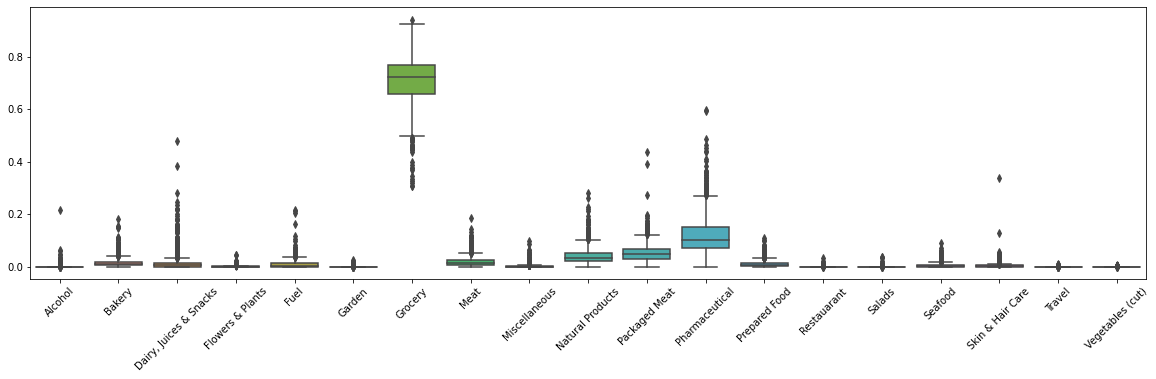

In [117]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=customer_item.iloc[:,2:])
plt.xticks(rotation=45)
plt.show()

#fig, axes = plt.subplots(figsize=(20, 5))
#axes = sns.boxplot(data=customer_item.iloc[:,2:])
#axes.set_xticklabels(ax.get_xticklabels(),rotation=30)

#plt.figure(figsize=(10,5))
#ax = sns.boxplot(data=customer_item.iloc[:,2:])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [118]:
old_cols = list(customer_item.columns)
old_cols.remove('customer_id')

new_cols = ['cus_'+i for i in old_cols]
new_cols = dict(zip(old_cols, new_cols))

customer_item.rename(columns=new_cols, inplace=True)
customer_item.head()

,customer_id,cus_Established,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Grocery,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut)
0,1501,0.834711,0.000000,0.002755,0.000000,0.000000,0.0,0.000000,0.754821,0.019284,0.002755,0.066116,0.044077,0.099174,0.008264,0.0,0.000000,0.002755,0.000000,0.000000,0.0
1,857,0.834395,0.000000,0.019108,0.004246,0.002123,0.0,0.002123,0.711253,0.040340,0.002123,0.025478,0.048832,0.106157,0.019108,0.0,0.002123,0.002123,0.014862,0.000000,0.0
2,67,0.620767,0.000000,0.000000,0.022573,0.000000,0.0,0.000000,0.769752,0.042889,0.002257,0.051919,0.036117,0.072235,0.002257,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,751,0.736527,0.028443,0.007485,0.017964,0.001497,0.0,0.004491,0.648204,0.019461,0.000000,0.049401,0.046407,0.161677,0.007485,0.0,0.000000,0.002994,0.004491,0.000000,0.0
4,679,0.902047,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.808480,0.013889,0.000000,0.022661,0.046053,0.076023,0.019737,0.0,0.000000,0.012427,0.000000,0.000731,0.0


1. Most customers buy Grocery items. Pharmaceutical items are commonly purchased items as well. 
2. Created a new dataframe customer_item to characterize the purchase preference of each customer.

In [119]:
customer_id_df = pd.merge(customer_item, demog, on='customer_id', how='left')
customer_id_df = pd.merge(customer_id_df, transaction_customer_avg, on='customer_id', how='left')
customer_id_df = pd.merge(customer_id_df, customer_trans, on='customer_id', how='left')

customer_id_df.head()

,customer_id,cus_Established,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Grocery,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut),age_range,marital_status,rented,family_size,no_of_children,income_bracket,avg_coupon_discount,avg_other_discount,avg_sales,avg_use_coupon_discount,avg_use_other_discount,monthly_cp_disc,monthly_ct_trans,monthly_other_disc,monthly_sales,monthly_freq_cp_disc,monthly_freq_other_disc
0,1501,0.834711,0.000000,0.002755,0.000000,0.000000,0.0,0.000000,0.754821,0.019284,0.002755,0.066116,0.044077,0.099174,0.008264,0.0,0.000000,0.002755,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.330468,17.750992,120.404132,0.085399,0.531680,46.997778,19.944444,349.390000,2408.776667,1.722222,10.555556
1,857,0.834395,0.000000,0.019108,0.004246,0.002123,0.0,0.002123,0.711253,0.040340,0.002123,0.025478,0.048832,0.106157,0.019108,0.0,0.002123,0.002123,0.014862,0.000000,0.0,70+,Single,0.0,1,unknown,7.0,2.525902,16.630743,103.575648,0.055202,0.503185,66.094444,24.888889,411.246667,2605.804444,1.444444,12.222222
2,67,0.620767,0.000000,0.000000,0.022573,0.000000,0.0,0.000000,0.769752,0.042889,0.002257,0.051919,0.036117,0.072235,0.002257,0.0,0.000000,0.000000,0.000000,0.000000,0.0,36-45,unknown,0.0,2,1,4.0,0.000000,11.190226,61.609639,0.000000,0.440181,0.000000,24.611111,275.403889,1516.281667,0.000000,10.833333
3,751,0.736527,0.028443,0.007485,0.017964,0.001497,0.0,0.004491,0.648204,0.019461,0.000000,0.049401,0.046407,0.161677,0.007485,0.0,0.000000,0.002994,0.004491,0.000000,0.0,26-35,Single,0.0,1,unknown,5.0,0.016003,20.102156,134.390674,0.001497,0.535928,0.593889,37.111111,746.013333,4987.387222,0.055556,19.888889
4,679,0.902047,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.808480,0.013889,0.000000,0.022661,0.046053,0.076023,0.019737,0.0,0.000000,0.012427,0.000000,0.000731,0.0,36-45,Single,1.0,2,unknown,4.0,0.000000,16.625892,114.893933,0.000000,0.554094,0.000000,76.000000,1263.567778,8731.938889,0.000000,42.111111


In [120]:
features_demog = list(demog.columns)
features_demog.remove('customer_id')

for i in features_demog:
    print("{} has {:.3f}% missing values.".format(i, customer_id_df[i].isnull().sum()/len(customer_id_df[i])*100))

age_range has 51.960% missing values.
marital_status has 51.960% missing values.
rented has 51.960% missing values.
family_size has 51.960% missing values.
no_of_children has 51.960% missing values.
income_bracket has 51.960% missing values.


In [121]:
customer_id_df.fillna('unknown', inplace=True)

In [122]:
train_raw = pd.merge(train, campaign, on='campaign_id', how='left') 
train_raw = pd.merge(train_raw, coupon_id_df, on='coupon_id', how='left')
train_raw = pd.merge(train_raw, customer_id_df, on='customer_id', how='left')

In [123]:
test_raw = pd.merge(test, campaign, on='campaign_id', how='left') 
test_raw = pd.merge(test_raw, coupon_id_df, on='coupon_id', how='left')
test_raw = pd.merge(test_raw, customer_id_df, on='customer_id', how='left')

In [124]:
# necessary for plot_categorical to work on "brand", "rented", "family_size" and 'income_bracket'
# (they have a mixture of numerical and string levels)

# necessary for plot_categorical to work on "num_it_in_cp_bin"
# (num_it_in_cp_bin was an Interval object)

def mix_to_str(df):
    
    df['brand'] = df['brand'].map(lambda x: str(x)+'b')
    df['rented'] = df['rented'].map(lambda x:
                                          'No' if x==0.0 else
                                          ('Yes' if x==1.0 else x))
    df['family_size'] =\
        df['family_size'].map(lambda x: '='+str(x))
    df['income_bracket'] =\
        df['income_bracket'].map(lambda x:
                                        '='+str(x)[:-2] if '.' in str(x)
                                        else '='+str(x))
    df.num_it_in_cp_bin = \
        df.num_it_in_cp_bin.map(lambda x: str(x))

    return None

In [125]:
mix_to_str(train_raw)
mix_to_str(test_raw)

In [126]:
train_raw.to_csv('train_raw.csv.zip')
test_raw.to_csv('test_raw.csv.zip')

# Exploratory data analysis

In [127]:
train_raw.head() 

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_duration,ct_brand,ct_category,brand,category,brand_type,num_it_in_cp_bin,cus_Established,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Grocery,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut),age_range,marital_status,rented,family_size,no_of_children,income_bracket,avg_coupon_discount,avg_other_discount,avg_sales,avg_use_coupon_discount,avg_use_other_discount,monthly_cp_disc,monthly_ct_trans,monthly_other_disc,monthly_sales,monthly_freq_cp_disc,monthly_freq_other_disc
0,1,13,27,1053,0,X,2013-05-19,2013-07-05,47,1,0,multipleb,Grocery,Established,"(100, 1000]",0.535484,0.000000,0.000000,0.000000,0.0,0.048387,0.0,0.690323,0.061290,0.000000,0.022581,0.093548,0.067742,0.003226,0.0,0.000000,0.012903,0.000000,0.0,0.0,46-55,unknown,No,=1,unknown,=5,0.287258,33.168935,184.260484,0.003226,0.538710,4.947222,16.888889,564.277222,3107.577222,0.055556,9.166667
1,2,13,116,48,0,X,2013-05-19,2013-07-05,47,0,0,56b,Grocery,Local,"(0, 5]",0.755844,0.000000,0.025974,0.002597,0.0,0.002597,0.0,0.618182,0.033766,0.007792,0.054545,0.080519,0.148052,0.010390,0.0,0.002597,0.012987,0.000000,0.0,0.0,36-45,Married,No,=2,unknown,=3,3.215039,27.699169,234.247013,0.031169,0.542857,77.361875,24.062500,666.511250,5636.568750,0.750000,13.062500
2,6,9,635,205,0,Y,2013-03-11,2013-04-12,32,0,0,560b,Pharmaceutical,Established,"(50, 100]",0.814433,0.000000,0.008247,0.007216,0.0,0.000000,0.0,0.731959,0.064948,0.001031,0.052577,0.022680,0.088660,0.017526,0.0,0.000000,0.001031,0.004124,0.0,0.0,46-55,Married,No,=2,unknown,=7,2.212082,17.795660,121.094495,0.087629,0.471134,134.107500,60.625000,1078.861875,7341.353750,5.312500,28.562500
3,7,13,644,1050,0,X,2013-05-19,2013-07-05,47,0,0,611b,Grocery,Established,"(0, 5]",0.531646,0.004219,0.042194,0.000000,0.0,0.000000,0.0,0.780591,0.000000,0.000000,0.004219,0.037975,0.113924,0.012658,0.0,0.000000,0.000000,0.004219,0.0,0.0,unknown,unknown,unknown,=unknown,unknown,=unknown,0.751477,16.655570,98.276034,0.008439,0.506329,10.476471,13.941176,232.198235,1370.083529,0.117647,7.058824
4,9,8,1017,1489,0,X,2013-02-16,2013-04-05,48,0,0,1558b,Grocery,Established,"(10, 50]",0.713523,0.000000,0.008897,0.000000,0.0,0.024911,0.0,0.718861,0.019573,0.021352,0.017794,0.103203,0.085409,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,46-55,Married,No,=2,unknown,=3,0.471548,20.524733,120.636103,0.017794,0.500000,17.667333,37.133333,762.700000,4489.698000,0.666667,18.533333


In [128]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          78369 non-null  int64         
 1   campaign_id                 78369 non-null  int64         
 2   coupon_id                   78369 non-null  int64         
 3   customer_id                 78369 non-null  int64         
 4   redemption_status           78369 non-null  int64         
 5   campaign_type               78369 non-null  object        
 6   start_date                  78369 non-null  datetime64[ns]
 7   end_date                    78369 non-null  datetime64[ns]
 8   campaign_duration           78369 non-null  int64         
 9   ct_brand                    78369 non-null  int64         
 10  ct_category                 78369 non-null  int64         
 11  brand                       78369 non-null  object    

Notes on further feature engineering:
1. campaign start_date and end_date may be used to create date-time features.
2. categorical features to be encoded: campaign_type, brand, category, brand_type, age_range, marital_status, rented, family_size, no_of_children, income_bracket

## Low-variance and missing values 

In [129]:
# Does any feature have single value? - No
train_single_val = []
for i in train_raw.columns:
    if len(train_raw[i].unique())==1:
        train_single_val.append(i)
print('Features in train_raw that only has one value\n',
      train_single_val)

Features in train_raw that only has one value
 []


In [130]:
# Customer related features have 'unknown' values

features_demog

for i in features_demog:
    print("{} has {:.3f}% missing values.".format(i, train_raw[train_raw[i]=='unknown'].shape[0]/len(train_raw[i])*100))

age_range has 44.288% missing values.
marital_status has 67.597% missing values.
rented has 44.288% missing values.
family_size has 0.000% missing values.
no_of_children has 82.064% missing values.
income_bracket has 0.000% missing values.


More than 44% of the customers have missing demographic information. The missing value reaches 68% for marital_status and 84% for no_of_children. At this high level of missing value, it may not be useful to include these two features. Therefore, I dropped them from train_raw.

In [131]:
feature_dropped_from_raw = []

feature_dropped_from_raw.append('marital_status')
feature_dropped_from_raw.append('no_of_children') 

In [132]:
feature_dropped_from_raw += ['id', 'campaign_id', 'coupon_id', 'customer_id']

In [133]:
feature_dropped_from_raw += ['start_date', 'end_date']

In [134]:
target_variable = ['redemption_status']

In [135]:
cat_features = ['campaign_type', 'ct_brand','ct_category',\
                'brand', 'category', 'brand_type',\
                'num_it_in_cp_bin', 'age_range', 'rented',\
                'family_size', 'income_bracket']
num_features = list(set(train_raw.columns) - set(feature_dropped_from_raw)\
                - set(cat_features) - set(target_variable))

## Categorical features vs. redemption_status

In [136]:
for f in cat_features:
    print('-------Value counts of {} in train_raw------\n'.format(f))
    print(train_raw[f].value_counts(), '\n')

-------Value counts of campaign_type in train_raw------

X    57684
Y    20685
Name: campaign_type, dtype: int64 

-------Value counts of ct_brand in train_raw------

0    69004
1     9365
Name: ct_brand, dtype: int64 

-------Value counts of ct_category in train_raw------

0    74010
1     4359
Name: ct_category, dtype: int64 

-------Value counts of brand in train_raw------

56b          15627
multipleb     9365
686b          1824
1134b         1566
946b          1430
             ...  
833b            25
1427b           17
706b            17
819b            17
4674b           17
Name: brand, Length: 265, dtype: int64 

-------Value counts of category in train_raw------

Grocery                   50677
Pharmaceutical            16715
multiple                   4359
Packaged Meat              1891
Prepared Food              1141
Dairy, Juices & Snacks     1102
Seafood                     859
Natural Products            616
Bakery                      573
Meat                        18

In [137]:
def plot_categorical(df, feature):

    feature_df = df.groupby(feature)["redemption_status"].sum().reset_index()
    feature_df['Sum'] = df.groupby(feature)["redemption_status"].count().values
    feature_df['Redeem_pct'] = feature_df.redemption_status.div(feature_df['Sum'])*100

    if len(feature_df[feature])>15:
        print('{} has >15 levels; no plot generated'.format(feature))
        return None
    else:
        fig, axes = plt.subplots(figsize=(12, 4))
        plt.bar(feature_df[feature], feature_df.Redeem_pct)
        if len(feature_df[feature])>5:
            plt.xticks(feature_df[feature], feature_df[feature],rotation='vertical')
        else:
            plt.xticks(feature_df[feature], feature_df[feature])
 
        plt.xlabel(feature)
        plt.ylabel('Redemption percentage (%)')

        labels = [str(round(i,2))+"%" for i in feature_df.Redeem_pct]

        for i in range(len(labels)):
            plt.text(feature_df[feature][i], feature_df.Redeem_pct[i], labels[i], ha='center', va='bottom')

        plt.show()

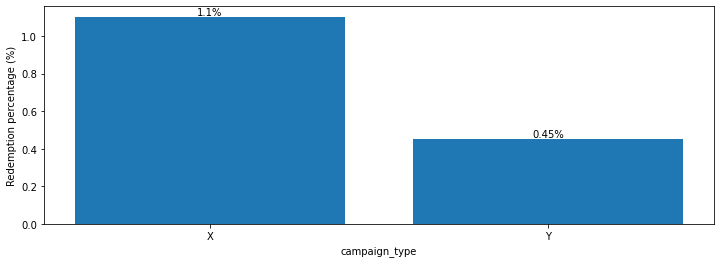

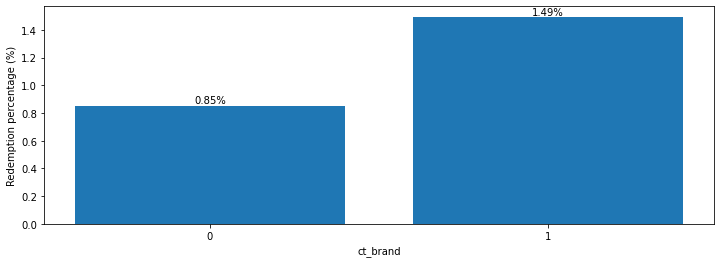

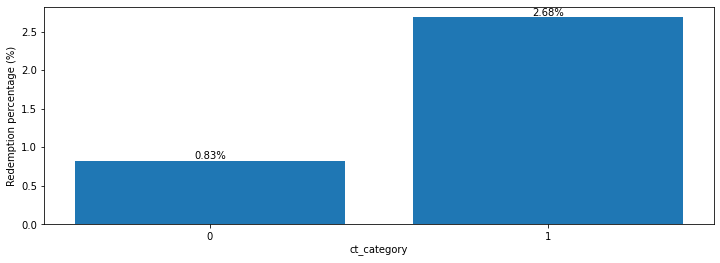

brand has >15 levels; no plot generated


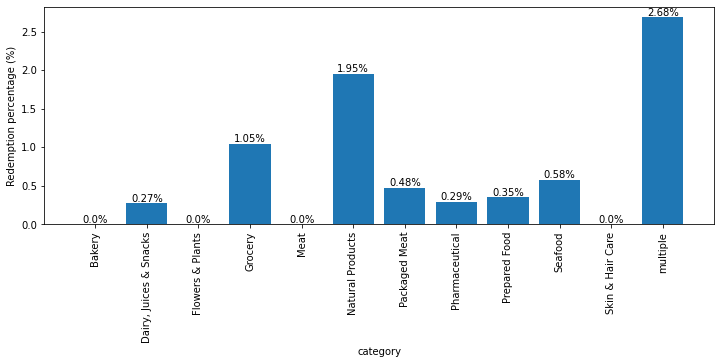

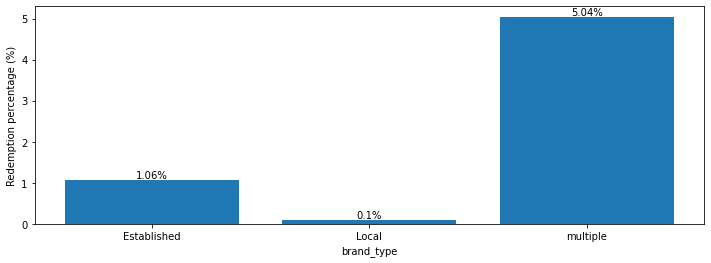

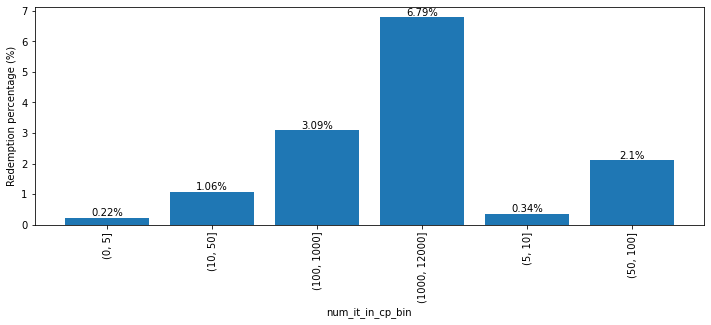

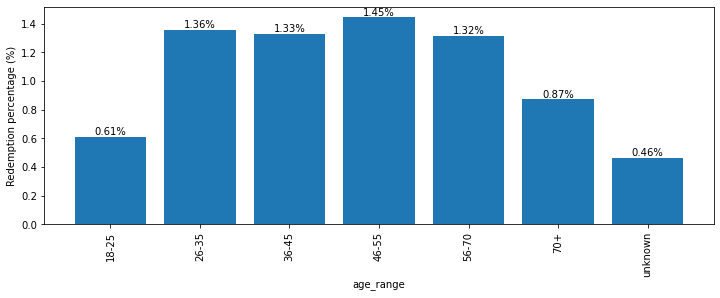

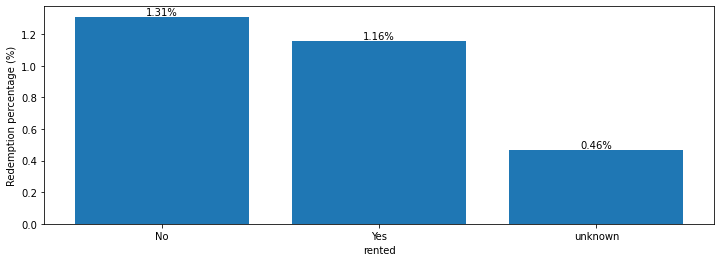

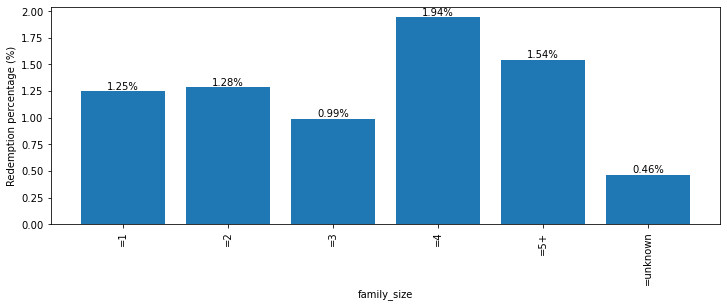

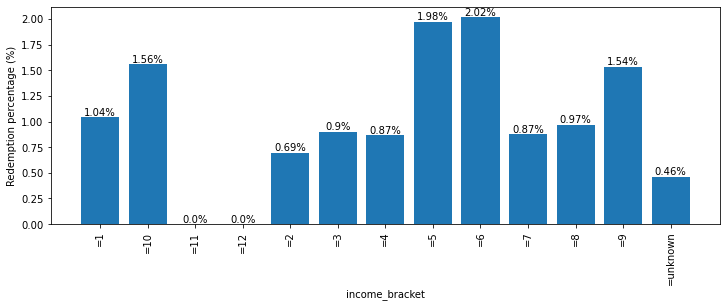

In [138]:
for f in cat_features:
    plot_categorical(train_raw, f)

- campaign_type: X has two-fold higher redemption rate than Y.
- ct_brand: If a coupon contains more than one brand, it has 75% more change to be redeemed.
- ct_category: Coupons covering more than one category have three times higher redemption rate.
- category: "multiple" and "Natural Products" show higher redemption rate. No redemption is observed for "Bakery", "Flowers & Plants", "Meat", and "Skin & Hair Care".
- brand_type: redemption rate is "multiple" > "Established" > "Local"
- num_it_in_cp_bin: The more items a coupon contains, the higher redemption rate the conpon is, as one may expect.
- age_range: "unknown", "18-25", and "70+" have lower redemption rate.
- rented: "unknown" has lower redemption rate.
- family_size: trend is unclear.
- income_bracket: the two highest income brackets do not redeem coupons; treand is unclear for other brackets.

In [139]:
# Here we can further use chi-squared statistical testing to see 
# if the target variable is dependent on each categorical feature 
# It requires at least 5 observations in each cell of the contingency
# table, which cannot be met with our highly imbalanced data.

# Here is an example with num_it_in_cp_bin (visually observed correlation):

cat_f = 'num_it_in_cp_bin'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')

significance=0.050, p=0.000
Variables are associated (reject H0)


In [140]:
# Here is an example with family_size (trend is unclear):

cat_f = 'family_size'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')
    
print(cat_f_crosstab)

significance=0.050, p=0.000
Variables are associated (reject H0)
family_size           =1     =2    =3    =4   =5+  =unknown
redemption_status                                          
0                  13442  16671  6205  3078  3697     34547
1                    170    217    62    61    58       161


In [141]:
# Here is an example with family_size (trend is unclear; certain cells have <5 observations):

cat_f = 'income_bracket'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')
    
print(cat_f_crosstab)

significance=0.050, p=0.000
Variables are associated (reject H0)
income_bracket       =1  =10  =11  =12    =2    =3    =4     =5    =6    =7  \
redemption_status                                                             
0                  3420  505  260  796  3865  3847  8677  10819  4757  1813   
1                    36    8    0    0    27    35    76    218    98    16   

income_bracket       =8    =9  =unknown  
redemption_status                        
0                  2346  1988     34547  
1                    23    31       161  


## Numerical features vs. redemption_status

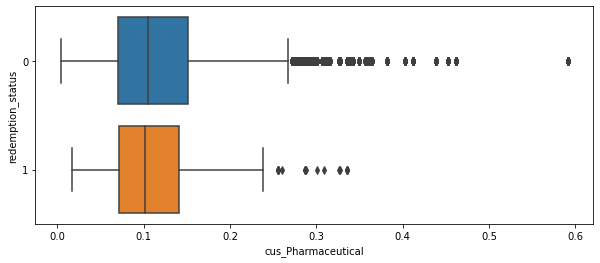

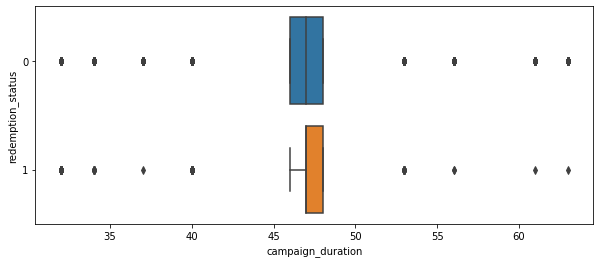

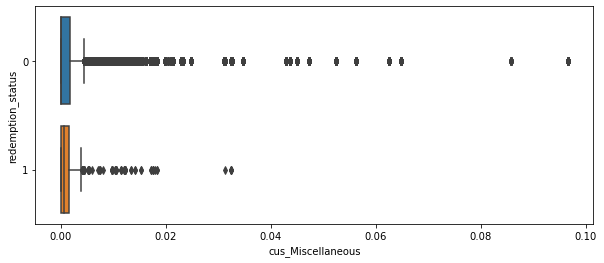

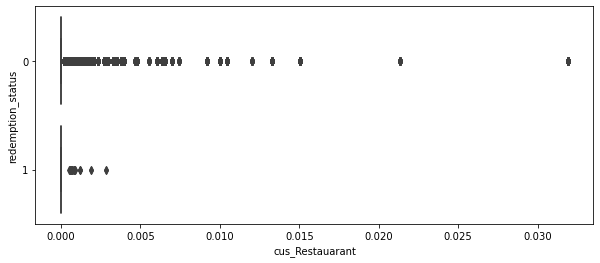

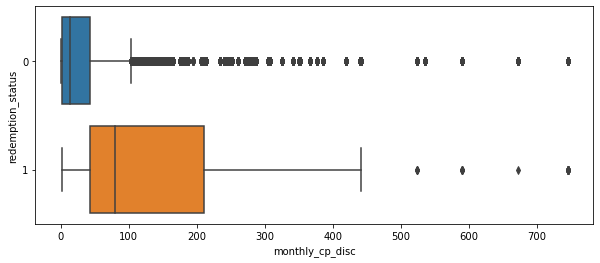

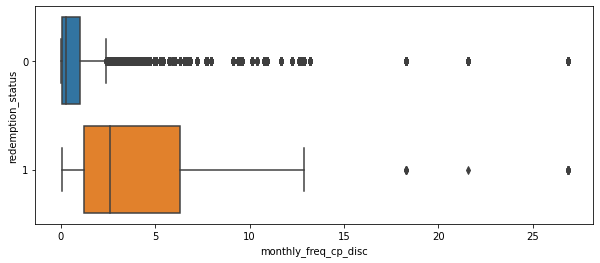

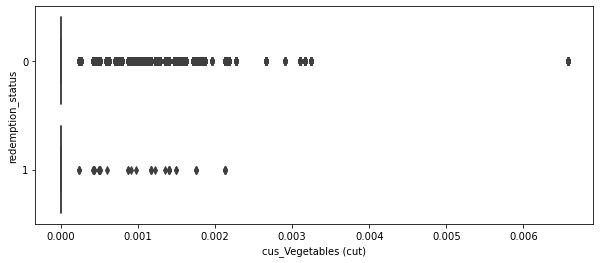

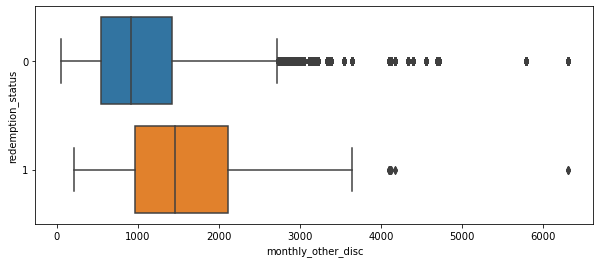

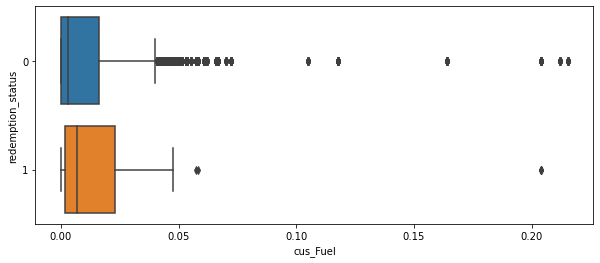

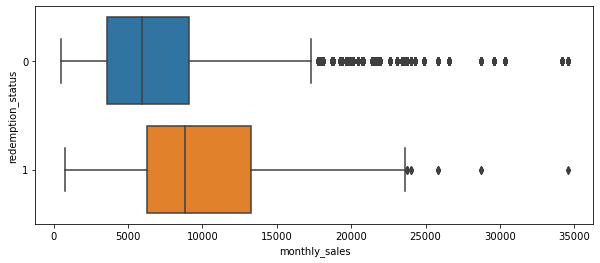

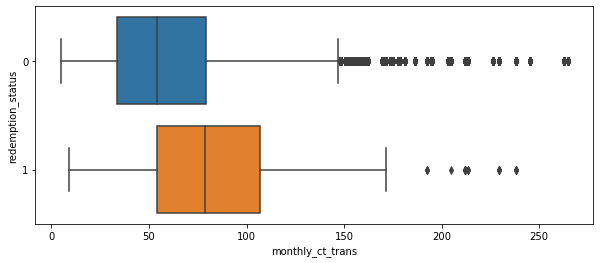

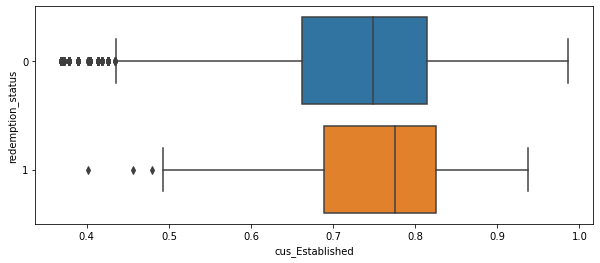

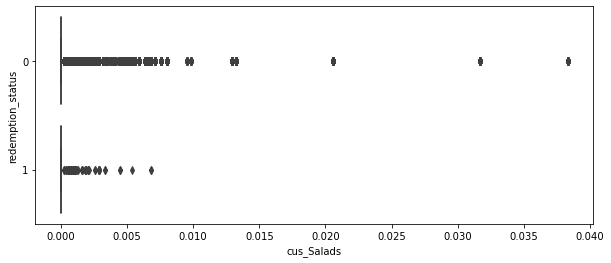

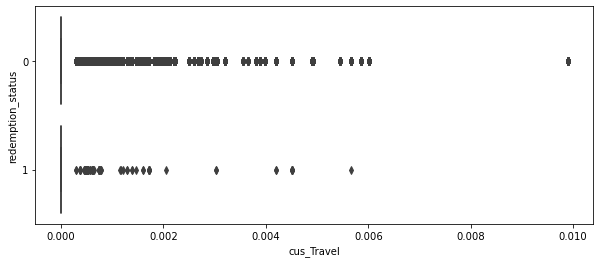

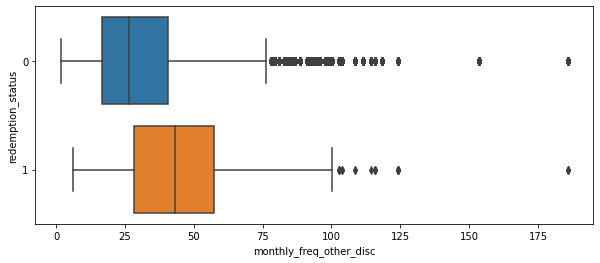

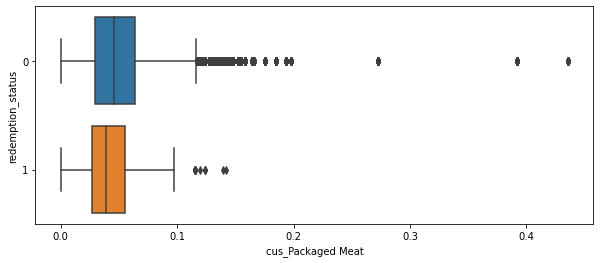

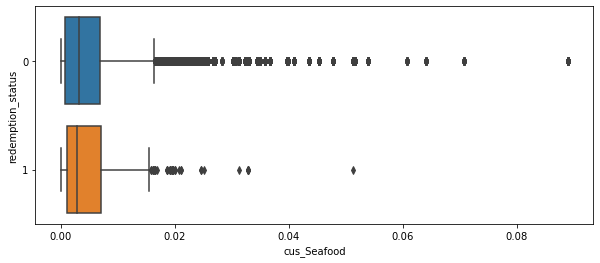

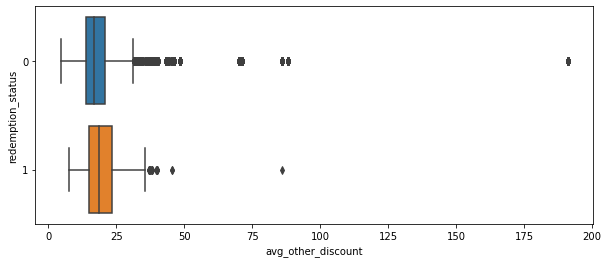

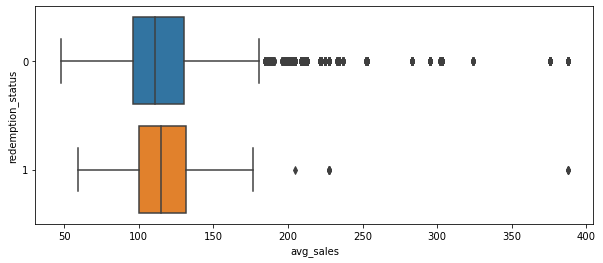

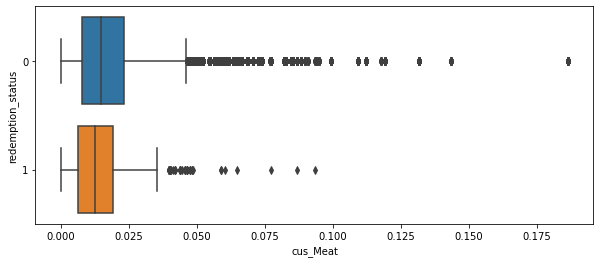

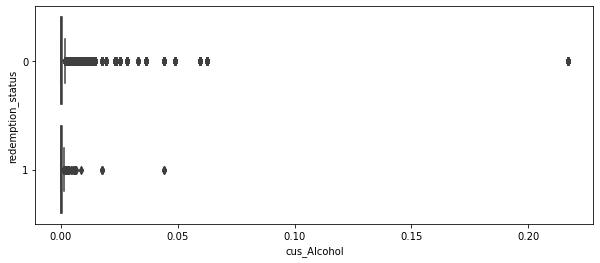

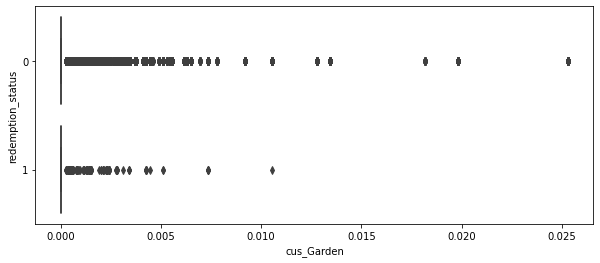

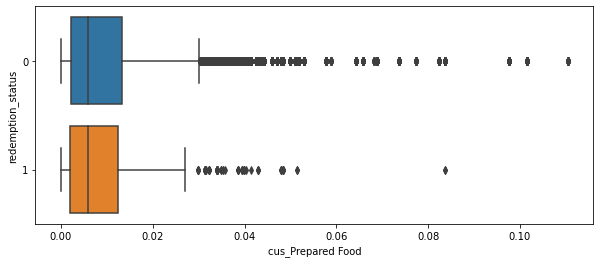

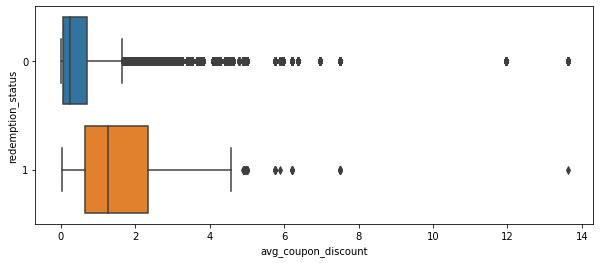

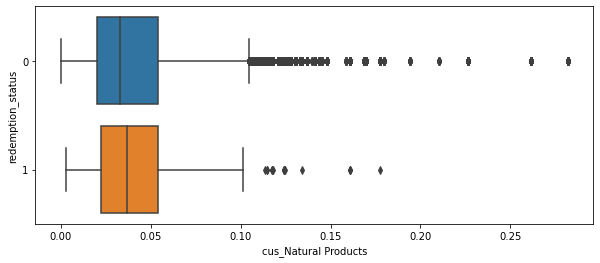

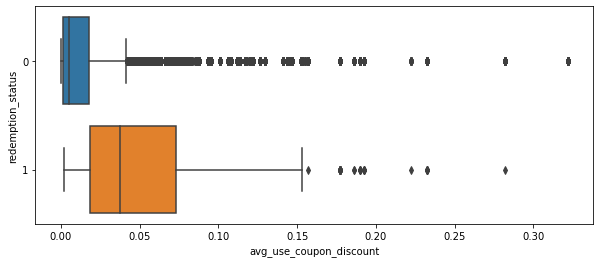

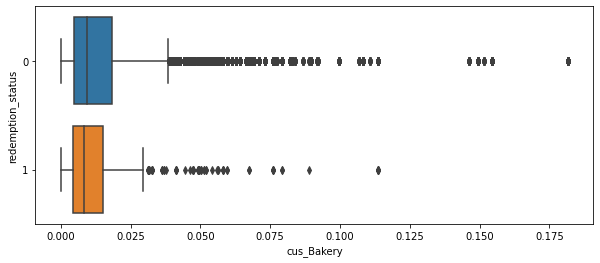

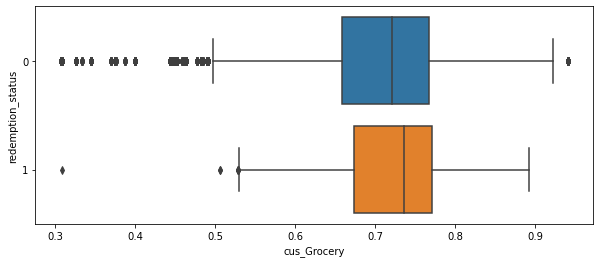

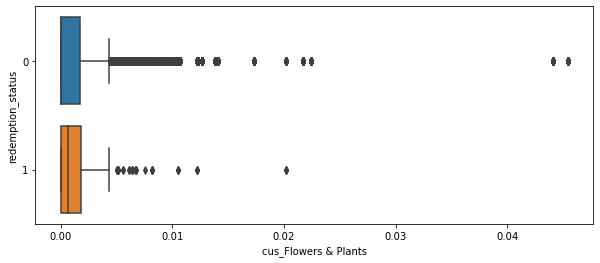

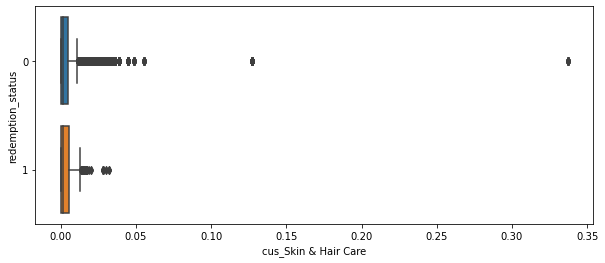

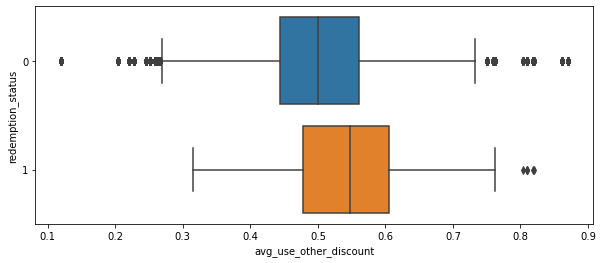

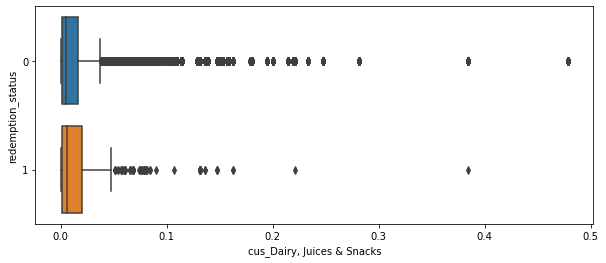

In [142]:
def plot_numerical(df, feature):
    figure(figsize=(10, 4))
    sns.boxplot(x=f, y="redemption_status", data=df, orient='h')
    plt.show()
    
for f in num_features:
    plot_numerical(train_raw, f)

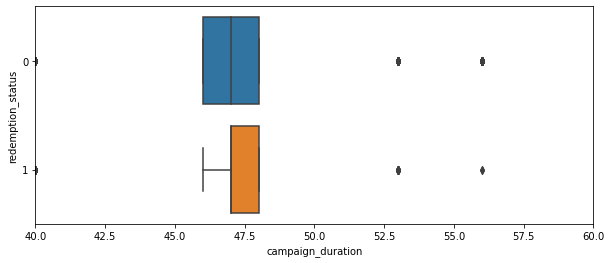

In [143]:
figure(figsize=(10, 4))
sns.boxplot(x="campaign_duration", y="redemption_status", data=train_raw, orient='h')
plt.xlim(40, 60)
plt.show()

- cp_in_camp: Does not appear to have different means between the two redemption status.
- cus_in_camp: Does not appear to have different means between the two redemption status.
- campaign_duration: longer duration seems to increase redemption.

In [144]:
len(num_features)

32

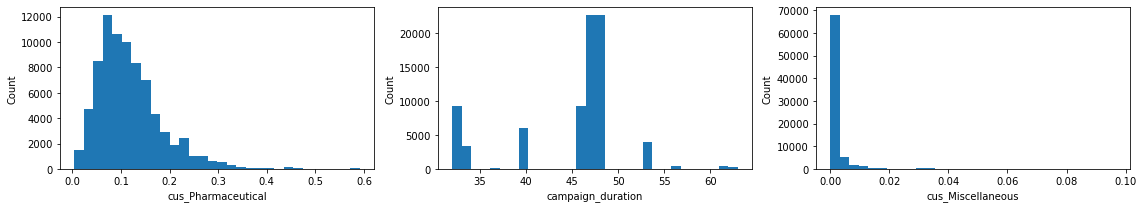

In [145]:
# The numerical features are obviously not Gaussian distributed.
# Therefore, statistical testing such as t-test is not appropriate.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))
for i in range(3):
    axes[i].hist(train_raw[num_features[i]], bins=30)
    axes[i].set_xlabel(num_features[i])
    axes[i].set_ylabel('Count')

fig.tight_layout()

# Code above only serves as histogram plot code example

## Remove multicollinearity

In [146]:
def strongCorr(df, limit):
    correlation_matrix = df.corr()
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):   # range(i)  -> This is bottom right triangle w/o diag line
            if abs(correlation_matrix.iloc[i, j]) > limit:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return correlated_features

In [147]:
correlated_features = strongCorr(train_raw[num_features], 0.7)
correlated_features

{'avg_coupon_discount',
 'avg_use_coupon_discount',
 'monthly_ct_trans',
 'monthly_freq_cp_disc',
 'monthly_freq_other_disc',
 'monthly_sales'}

In [148]:
# VIF method may be better because it detects multicollinearity, not just pairwise collinearity

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i)\
                  for i in range(X.shape[1])]
    return vif

In [149]:
%%time

num_features_copy = num_features.copy()
train_raw_copy = train_raw.copy()
multicol_variables = []

while True:
    
    vif = calc_vif(train_raw_copy[num_features_copy])
    vif.sort_values('VIF', axis=0, ascending=False, inplace=True)
    print('Top two VIF variables:\n', vif.head(2))
    
    if vif.VIF.max()<5.1:
        break
    else:    
        #del_var = vif[vif.VIF == vif.VIF.max()].iloc[0,0]
        del_var = vif.iloc[0,0]
        print('variable to delete: ', del_var, '\n')
        multicol_variables.append(del_var)
        train_raw_copy.drop(columns=[del_var], inplace=True)
        num_features_copy.remove(del_var)

print('\nDeleted variables: ', multicol_variables)

Top two VIF variables:
            variables         VIF
27       cus_Grocery  188.325024
10  monthly_ct_trans   64.142252
variable to delete:  cus_Grocery 

Top two VIF variables:
                   variables         VIF
10         monthly_ct_trans  141.669182
14  monthly_freq_other_disc  107.615580
variable to delete:  monthly_ct_trans 

Top two VIF variables:
                   variables        VIF
28   avg_use_other_discount  72.144476
13  monthly_freq_other_disc  60.439810
variable to delete:  avg_use_other_discount 

Top two VIF variables:
           variables        VIF
4   monthly_cp_disc  53.002704
17        avg_sales  51.979272
variable to delete:  monthly_cp_disc 

Top two VIF variables:
           variables        VIF
16        avg_sales  51.321564
9   cus_Established  43.472999
variable to delete:  avg_sales 

Top two VIF variables:
             variables        VIF
6  monthly_other_disc  41.348812
9     cus_Established  36.624475
variable to delete:  monthly_other_disc 



In [150]:
feature_dropped_from_raw += multicol_variables

In [151]:
num_features = list(set(num_features)-set(multicol_variables))

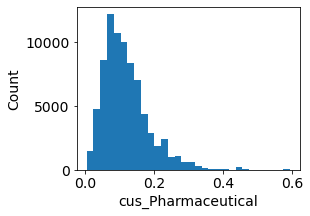

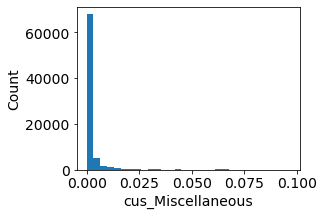

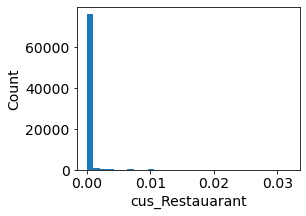

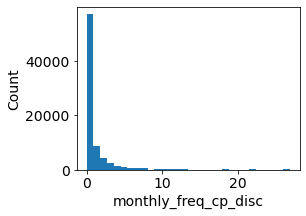

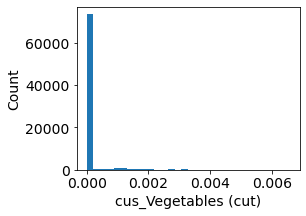

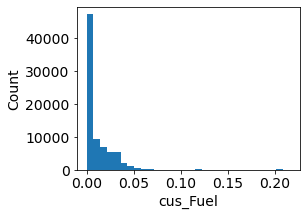

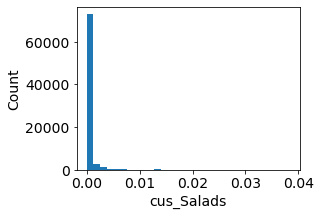

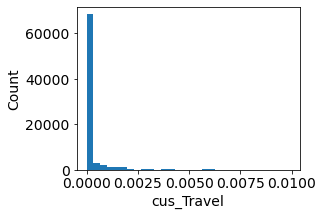

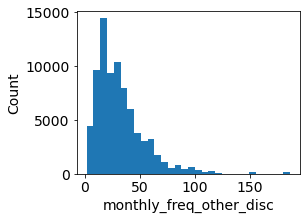

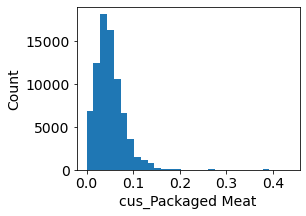

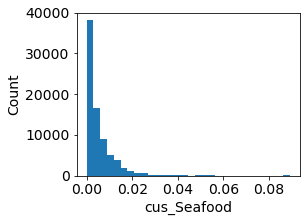

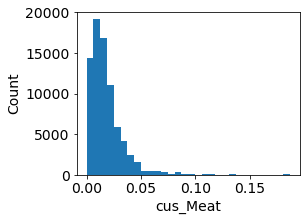

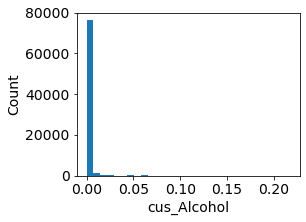

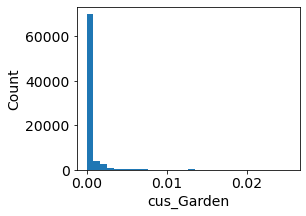

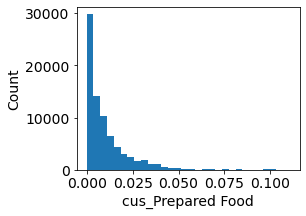

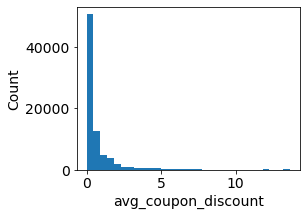

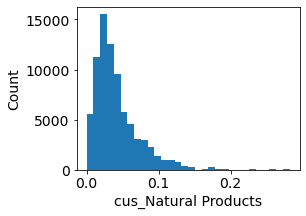

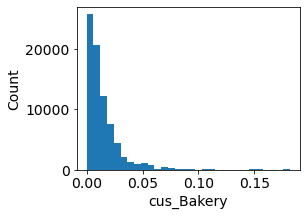

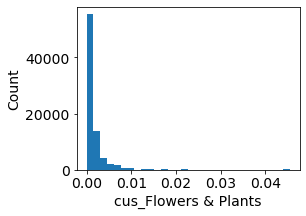

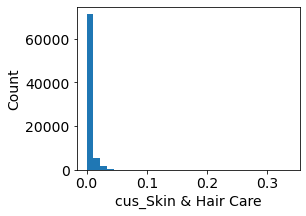

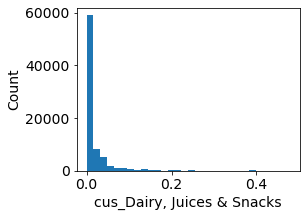

In [186]:
def plot_num_distr(df, feature):
    fig, axes = plt.subplots(figsize=(4, 3))
    plt.hist(df[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

for f in num_features:
    plot_num_distr(train_raw, f)

From the figures above, some of the transaction features exhibit near-normal distribution, while others are heavily skewed (left or right).

For the features with near-normal distribution, we can perform ANOVA tests to examine their correlation with the target variable. Other features may not.

Considering that the number of transaction features is not small (27), I skipped examining feature-target variable correlation. Instead, I will use feature importance after initial model building to inform feature downselection.

In [153]:
# def dropFeature(df, removed_cols):
#       return df.drop(removed_cols, axis=1)

In [154]:
# brand has too many levels, drop
feature_dropped_from_raw += ['brand']

In [155]:
train_X_y = train_raw.drop(columns=feature_dropped_from_raw)
test_X = test_raw.drop(columns=feature_dropped_from_raw)

#train_X_y.to_csv('train_X_y.csv.zip')
#test_X.to_csv('test_X.csv.zip')

In [156]:
train_X_y.head()

,redemption_status,campaign_type,ct_brand,ct_category,category,brand_type,num_it_in_cp_bin,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut),age_range,rented,family_size,income_bracket,avg_coupon_discount,monthly_freq_cp_disc,monthly_freq_other_disc
0,0,X,1,0,Grocery,Established,"(100, 1000]",0.000000,0.000000,0.000000,0.0,0.048387,0.0,0.061290,0.000000,0.022581,0.093548,0.067742,0.003226,0.0,0.000000,0.012903,0.000000,0.0,0.0,46-55,No,=1,=5,0.287258,0.055556,9.166667
1,0,X,0,0,Grocery,Local,"(0, 5]",0.000000,0.025974,0.002597,0.0,0.002597,0.0,0.033766,0.007792,0.054545,0.080519,0.148052,0.010390,0.0,0.002597,0.012987,0.000000,0.0,0.0,36-45,No,=2,=3,3.215039,0.750000,13.062500
2,0,Y,0,0,Pharmaceutical,Established,"(50, 100]",0.000000,0.008247,0.007216,0.0,0.000000,0.0,0.064948,0.001031,0.052577,0.022680,0.088660,0.017526,0.0,0.000000,0.001031,0.004124,0.0,0.0,46-55,No,=2,=7,2.212082,5.312500,28.562500
3,0,X,0,0,Grocery,Established,"(0, 5]",0.004219,0.042194,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.004219,0.037975,0.113924,0.012658,0.0,0.000000,0.000000,0.004219,0.0,0.0,unknown,unknown,=unknown,=unknown,0.751477,0.117647,7.058824
4,0,X,0,0,Grocery,Established,"(10, 50]",0.000000,0.008897,0.000000,0.0,0.024911,0.0,0.019573,0.021352,0.017794,0.103203,0.085409,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,46-55,No,=2,=3,0.471548,0.666667,18.533333


# Modeling

In [157]:
y_train = train_X_y['redemption_status']
X_train = train_X_y.drop(columns=['redemption_status'])

In [158]:
X_train.columns == test_X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## Split train dataset to train and validation

Normally this is where the dataset is split to train and test (both with target variables). Validation dataset is not required if using GridSearchCV because validation is intrinsically avaialble in GridSearchCV.

In [159]:
# split into train/test sets with same class ratio
trainX, validX, trainy, validy =\
    train_test_split(X_train, y_train, test_size=0.5,
                     random_state=0, stratify=y_train)

# summarize dataset
print('Dataset: Class0=%d, Class1=%d' %
      (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Train: Class0=%d, Class1=%d' % 
      (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Validation: Class0=%d, Class1=%d' % 
      (len(validy[validy==0]), len(validy[validy==1])))

Dataset: Class0=77640, Class1=729
Train: Class0=38820, Class1=364
Validation: Class0=38820, Class1=365


## Feature transformer pipeline

In [160]:
numerical_f = list(trainX.select_dtypes(include=['int64', 'float64']).columns)
categorical_f = list(trainX.select_dtypes(include=['object', 'bool']).columns)

# categorical_f = trainX.columns[trainX.dtypes==object].tolist()

In [161]:
# Define preprocessing transformer
preprocessor = ColumnTransformer(
    [
        ('scale', RobustScaler(), numerical_f),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_f)
    ]
    # remainder='drop'
)

In [162]:
%%time
# Check if transformer works properly
preprocessor.fit(trainX)

categorical_col = preprocessor.named_transformers_['encoder'].get_feature_names(categorical_f)
columns = numerical_f + list(categorical_col)

display(pd.DataFrame(preprocessor.transform(trainX), columns=columns))

,ct_brand,ct_category,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut),avg_coupon_discount,monthly_freq_cp_disc,monthly_freq_other_disc,campaign_type_X,campaign_type_Y,category_Bakery,"category_Dairy, Juices & Snacks",category_Flowers & Plants,category_Grocery,category_Meat,category_Natural Products,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Seafood,category_Skin & Hair Care,category_multiple,brand_type_Established,brand_type_Local,brand_type_multiple,"num_it_in_cp_bin_(0, 5]","num_it_in_cp_bin_(10, 50]","num_it_in_cp_bin_(100, 1000]","num_it_in_cp_bin_(1000, 12000]","num_it_in_cp_bin_(5, 10]","num_it_in_cp_bin_(50, 100]",age_range_18-25,age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,age_range_70+,age_range_unknown,rented_No,rented_Yes,rented_unknown,family_size_=1,family_size_=2,family_size_=3,family_size_=4,family_size_=5+,family_size_=unknown,income_bracket_=1,income_bracket_=10,income_bracket_=11,income_bracket_=12,income_bracket_=2,income_bracket_=3,income_bracket_=4,income_bracket_=5,income_bracket_=6,income_bracket_=7,income_bracket_=8,income_bracket_=9,income_bracket_=unknown
0,0.0,0.0,0.000000,-0.511491,-0.252381,0.000000,1.013956,0.0,0.155674,1.790903,-0.851657,0.060863,1.666990,-0.467099,0.0,0.000000,-0.508081,-0.358748,0.000000,0.0,-0.236417,-0.027566,1.170419,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.411576,1.415574,0.441515,0.911576,-0.190402,0.0,-0.221119,0.000000,0.550382,-0.468569,-0.740379,2.664000,0.0,0.001608,-0.248595,-0.358748,0.001608,0.0,0.504144,0.507999,-0.201421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.000000,-0.380231,-0.089754,0.000000,-0.190402,0.0,0.265374,0.817592,0.306256,1.826346,-0.673488,-0.199112,0.0,0.000000,1.004683,1.736061,0.000000,0.0,-0.221308,-0.072196,0.673672,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.000000,0.546397,-0.340132,0.000000,0.507668,0.0,-0.214839,0.000000,-0.509710,-0.549887,-0.195726,-0.524038,0.0,0.000000,-0.324879,0.402319,0.000000,0.0,0.187800,0.018459,0.148854,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,7.812500,-0.087841,1.034496,0.000000,-0.190402,0.0,-0.004915,0.000000,0.848870,0.046409,-0.895357,0.039303,0.0,0.000000,-0.339955,-0.358748,0.000000,0.0,0.386312,1.043564,0.127930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39179,0.0,0.0,0.000000,0.954860,-0.182994,1.282805,-0.051262,0.0,-0.511185,0.000000,2.456670,0.909146,0.673504,-0.524038,0.0,0.000000,3.873827,0.652564,0.000000,0.0,0.371618,-0.094511,-0.242250,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

CPU times: user 427 ms, sys: 59.8 ms, total: 487 ms
Wall time: 524 ms


## Model pipeline and model performance

In [163]:
def plot_roc_auc(clf, X, y):

    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)[:,1]
    
    # ROC_AUC
    fpr, tpr, thres = roc_curve(y, y_score)
    auc_score = roc_auc_score(y, y_score)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y))]
    p_fpr, p_tpr, _ = roc_curve(y, random_probs)

    # plot roc curve
    plt.plot(fpr, tpr, color='black')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.rcParams['font.size'] = 14
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    bbox_prop = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
    plt.text(0.8, 0.2, "ROC AUC = {:.3f}".format(auc_score), ha="center", va="center",
                size=10, bbox=bbox_prop)
    plt.show()

def plot_pr_auc(clf, X, y):

    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)[:,1]
    
    # PR AUC
    pre, rec, thres = precision_recall_curve(y, y_score)
    auc_score = auc(rec, pre)   # precision first arg, recall second! 

    # plot PR curve
    plt.plot(rec, pre, color='black')
    plt.rcParams['font.size'] = 14
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    bbox_prop = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
    plt.text(0.8, 0.2, "PR AUC = {:.3f}".format(auc_score), ha="center", va="center",
                size=10, bbox=bbox_prop)
    plt.show()
    # can also use build-in function: plot_precision_recall_curve

### Random forest model

In [164]:
# Create base model to tune

rf_clf = RandomForestClassifier(
                      class_weight="balanced",
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=0,
                      max_features='auto')


# Use GridSearchCV to tune hyperparameters.

param_grid = {'n_estimators': [100, 200, 300], 
              'max_depth': [3, 5, 10],
             'min_samples_leaf': range(30, 150, 30), 
             'min_samples_split': [2, 3, 5]}

grid_search = GridSearchCV(rf_clf, param_grid, 
                           cv=3, n_jobs=-1, scoring='roc_auc')

In [165]:
%%time

grid_search_pipe = Pipeline([
    ('prep', preprocessor),
    ('gs', grid_search)
])

grid_search_pipe.fit(trainX, trainy)
# 6min 51s

CPU times: user 7.35 s, sys: 622 ms, total: 7.97 s
Wall time: 6min 7s


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scale', RobustScaler(),
                                                  ['ct_brand', 'ct_category',
                                                   'cus_Alcohol', 'cus_Bakery',
                                                   'cus_Dairy, Juices & Snacks',
                                                   'cus_Flowers & Plants',
                                                   'cus_Fuel', 'cus_Garden',
                                                   'cus_Meat',
                                                   'cus_Miscellaneous',
                                                   'cus_Natural Products',
                                                   'cus_Packaged Meat',
                                                   'cus_Pharmaceutical',
                                                   'cus_Prepared Food',
                                                   'cus_Restauarant',
            

In [166]:
grid_search_pipe[1].best_params_

{'max_depth': 10,
 'min_samples_leaf': 30,
 'min_samples_split': 2,
 'n_estimators': 100}

In [167]:
# Build the model pipeline with the optimal hyperparameters
best_params = grid_search_pipe[1].best_params_

rf_clf = RandomForestClassifier(
                      class_weight="balanced",
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=0,
                      max_features='auto',
                      **best_params)

rf_clf_pipe = Pipeline([
    ('prep', preprocessor),
    ('rf', rf_clf)])

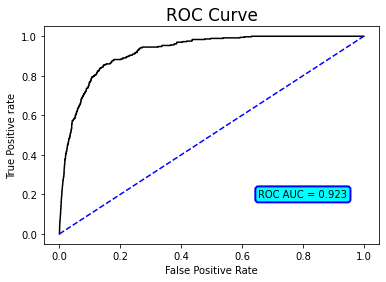

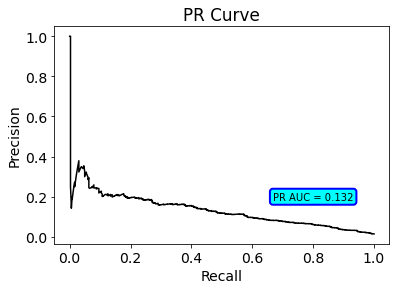

In [168]:
# Train the model to get test(validation) score
rf_clf_pipe.fit(trainX, trainy)

plot_roc_auc(rf_clf_pipe, validX, validy)
plot_pr_auc(rf_clf_pipe, validX, validy)

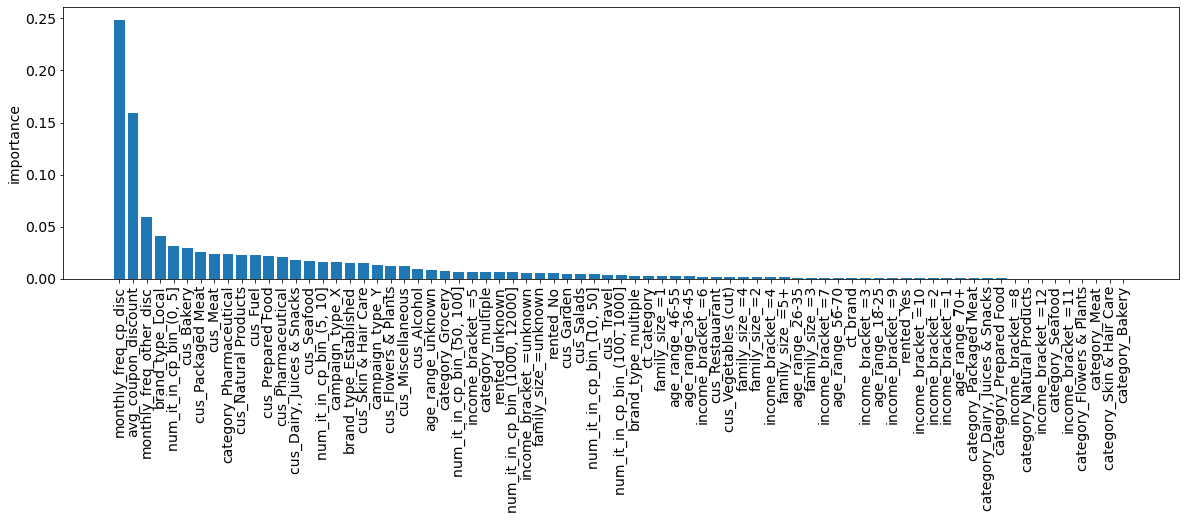

In [169]:
# Visualize the feature importance

importance = pd.DataFrame()

importance['feature'] = columns
importance['importance'] = rf_clf_pipe[1].feature_importances_
importance.sort_values('importance', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(20,5))
plt.bar(x=importance['feature'], height=importance['importance'])
plt.ylabel('importance')
plt.xticks(rotation='vertical')
#plt.title('Feature Importance', pad=15, size=15)
plt.show()

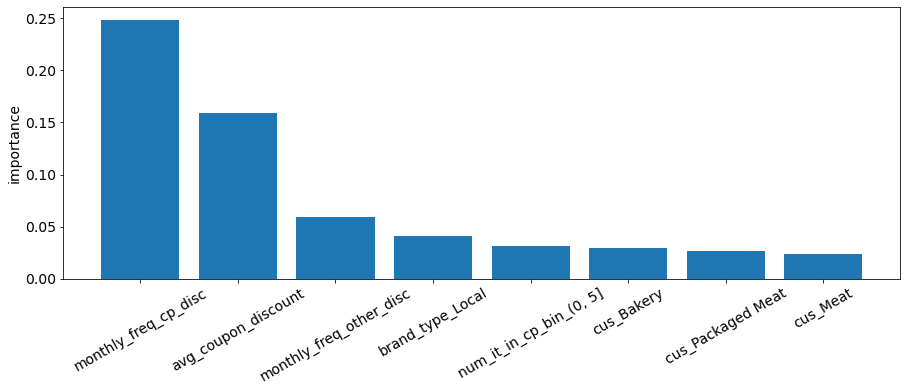

In [170]:
# Select top features

top = 8

plt.figure(figsize=(15,5))
plt.bar(x=importance['feature'][:top], height=importance['importance'][:top])
plt.ylabel('importance')
plt.xticks(rotation=30)
#plt.title('Feature Importance', pad=15, size=15)
plt.show()

**<font color=red>How to explain feature importance and generate insights?**

Partial dependency plot is available in ensemble models  !!!

思路：

如果网页输入是campaign_id, customer_id, coupon_id:
1. app.py中调用campaign.pkl, coupon_id_df.pkl, customer_id_df.pkl, 手动找到对应row，手动merge，生成test_raw。
2. app.py中，pickle调用features_dropped_from_raw，把test_raw中的一些features drop掉。
3. 如果是tree models, 还是要encoding，然后送去用pipeline object (model.pkl) predict了。
4. 如果是logistic regression，需要encoding。
    - encoding可能是pipeline object的一部分（比如ColumnTransformer: (OneHotEncoder() transformer for categorical features), (scaler for numerical features))。然后直接送去model prediction.
    - 如果encoding完了之后还想看collinearity呢？这个... George是说onehotencoder之后的0和1是数值，也可以用pearson correlation or VIF。
    
To-do:
1. 我还想查一下categorical feature how to deal association or multicollinearity
2. 把notebook继续清理到建模那块
3. Random Forest model
4. XGBoost model



### Logistic regression

#### Benchmark logistic regression model

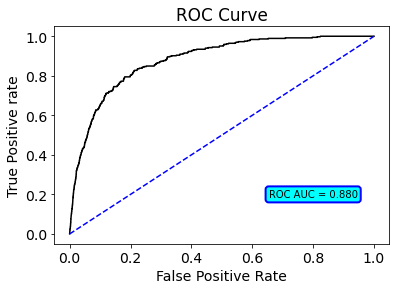

In [171]:
lr_clf_pipe = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(class_weight='balanced'))])

lr_clf_pipe.fit(trainX, trainy)

plot_roc_auc(lr_clf_pipe, validX, validy)

#### Using resampling technique

In [172]:
from imblearn.over_sampling import SMOTE
# SMOTE cannot take strings, must convert to numerical values first

In [173]:
trainX_processed = preprocessor.fit_transform(trainX)
validX_processed = preprocessor.transform(validX)

In [174]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

LogisticRegression()
AUC for 0.1: 0.8732871772070604
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.25: 0.8734330559731249
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.33: 0.8736459810999837
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.5: 0.8748848566972257
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.7: 0.8752675855546851
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for even: 0.8763828135475994
-------------------------------------------------------------------------------------


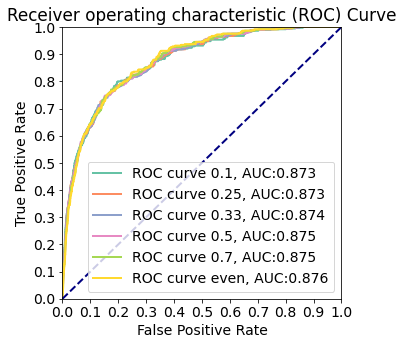

In [175]:
plt.figure(figsize=(5, 5))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=0, k_neighbors=5, n_jobs=-1)
    X_train_resampled, y_train_resampled = smote.fit_resample(trainX_processed, trainy) 
    logreg = LogisticRegression()
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)
    
    # Predict
    y_valid_pred = logreg.predict(validX_processed)

    y_valid_prob = logreg.predict_proba(validX_processed)

    fpr, tpr, thres = roc_curve(validy, y_valid_prob[:,1])
    # or, fpr, tpr, thres = roc_curve(validy, logreg.decision_function(validX))

    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    plt.plot(fpr, tpr, color=colors[n],
             lw=2, label='ROC curve {}, AUC:{}'.format(names[n], round(auc(fpr, tpr),3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.yticks([i/10.0 for i in range(11)])
plt.xticks([i/10.0 for i in range(11)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression()
AUC for 0.1: 0.10922660985708234
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.25: 0.10305301905781925
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.33: 0.09985603614651263
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.5: 0.09473446726506679
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.7: 0.09163657049109372
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for even: 0.0867857606942376
-------------------------------------------------------------------------------------


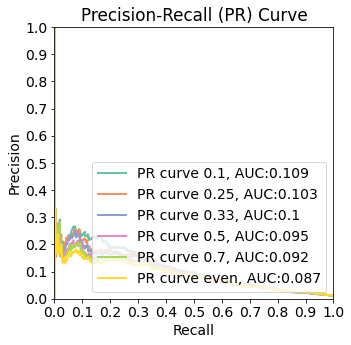

In [176]:
plt.figure(figsize=(5, 5))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=0, k_neighbors=5, n_jobs=-1)
    X_train_resampled, y_train_resampled = smote.fit_resample(trainX_processed, trainy) 
    logreg = LogisticRegression()
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)
    
    # Predict
    y_valid_pred = logreg.predict(validX_processed)

    y_valid_prob = logreg.predict_proba(validX_processed)

    pre, rec, thres = precision_recall_curve(validy, y_valid_prob[:,1])
    
    print('AUC for {}: {}'.format(names[n], auc(rec, pre)))
    print('-------------------------------------------------------------------------------------')
    plt.plot(rec, pre, color=colors[n],
             lw=2, label='PR curve {}, AUC:{}'.format(names[n], round(auc(rec, pre),3)))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.yticks([i/10.0 for i in range(11)])
plt.xticks([i/10.0 for i in range(11)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower right')
plt.show()

#### Grid search on class_weight

Scorer is ROC AUC

In [177]:
# define model
logreg = LogisticRegression()

# define hyperparameters
# note: {0:1.0,1:1.0} does not yield the same results as 'balanced'
w = [{0:100,1:1.0}, {0:10,1:1.0}, {0:1.0,1:1.0},{0:1.0,1:10}, {0:1.0,1:30}, {0:1.0,1:100}]
crange = [0.1, 0.3, 1, 3, 10]

param_grid = {"class_weight": w
               ,"penalty": ["l1", "l2"]
               ,"C": crange
               ,"fit_intercept": [True, False]  }

# define evaluation procedure
def roc_auc_scorer(estimator, X, y):
    y_score = estimator.predict_proba(X)[:,1]
    fpr, tpr, thres = roc_curve(y, y_score)
    return auc(fpr, tpr)
    # maybe can just use scoring='roc_auc'
    
grid_search = GridSearchCV(logreg, param_grid, 
                           cv=3, n_jobs=-1, scoring=roc_auc_scorer)


grid_search_pipe = Pipeline([
    ('prep', preprocessor),
    ('gs', grid_search)
])

In [178]:
t0 = time.time()

grid_search_pipe.fit(trainX,trainy)
print(f'Best score: {grid_search_pipe[1].best_score_} with param: {grid_search_pipe[1].best_params_}')

t1 = time.time()
total = t1-t0
print("mins:",round(total/60, 5))

Best score: 0.8714789672244923 with param: {'C': 0.1, 'class_weight': {0: 1.0, 1: 100}, 'fit_intercept': False, 'penalty': 'l2'}
mins: 0.57239


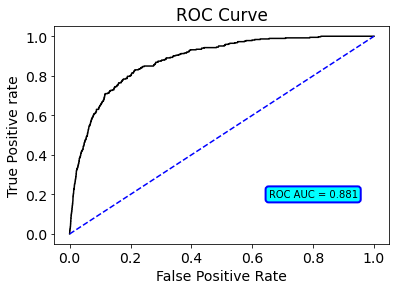

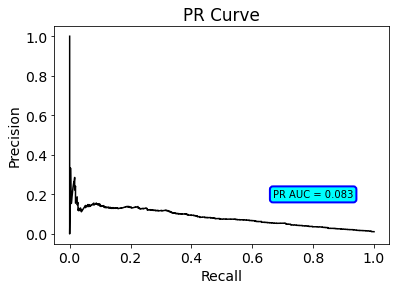

In [179]:
# Build the model pipeline with the optimal hyperparameters
best_params = grid_search_pipe[1].best_params_

lr_clf = LogisticRegression(**best_params)

lr_clf_pipe = Pipeline([
    ('prep', preprocessor),
    ('lr', lr_clf)])

# Train the model to get test(validation) score
lr_clf_pipe.fit(trainX, trainy)

plot_roc_auc(lr_clf_pipe, validX, validy)
plot_pr_auc(lr_clf_pipe, validX, validy)

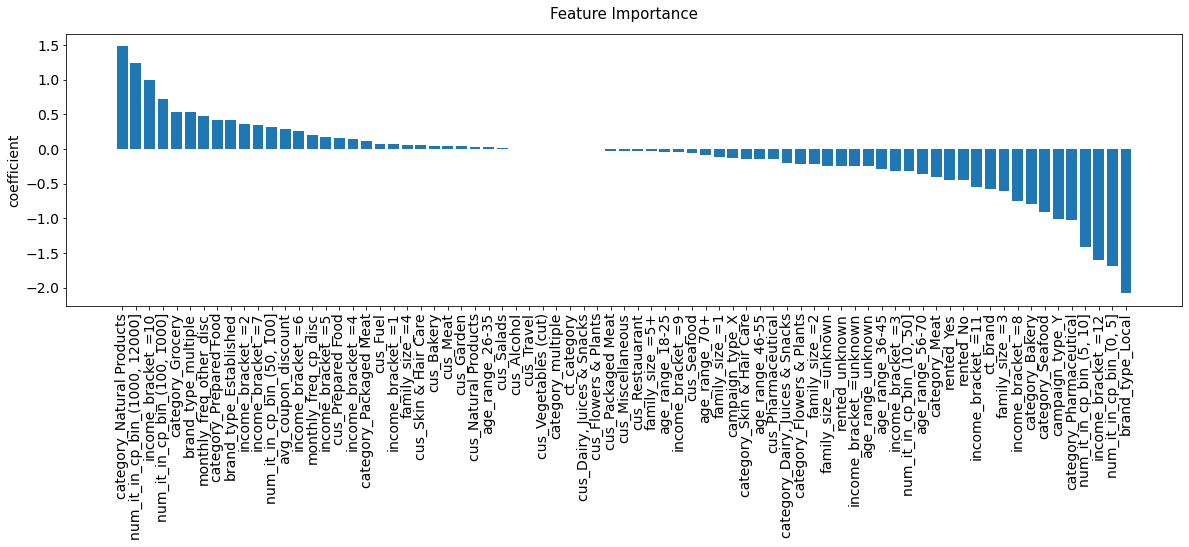

In [180]:
# Visualize the feature importance

importance = pd.DataFrame()

importance['feature'] = columns
importance['coefficient'] = lr_clf_pipe[1].coef_[0]
importance.sort_values('coefficient', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(20,5))
plt.bar(x=importance['feature'], height=importance['coefficient'])
plt.ylabel('coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)
plt.show()

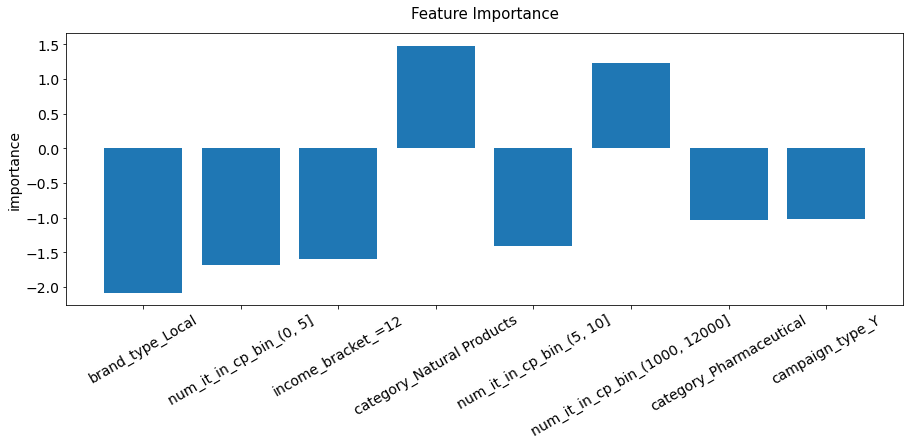

In [181]:
# Select top features

top = 8

importance['abs_coefficient'] = np.abs(importance['coefficient'])
importance.sort_values('abs_coefficient', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(15,5))
plt.bar(x=importance['feature'][:top], height=importance['coefficient'][:top])
plt.ylabel('importance')
plt.xticks(rotation=30)
plt.title('Feature Importance', pad=15, size=15)
plt.show()

# Customer segmentation

Due to high percentage of missing value in demographics, I decided to do customer segmentation only on purchase behavior.

In [182]:
customer_item.head()

,customer_id,cus_Established,cus_Alcohol,cus_Bakery,"cus_Dairy, Juices & Snacks",cus_Flowers & Plants,cus_Fuel,cus_Garden,cus_Grocery,cus_Meat,cus_Miscellaneous,cus_Natural Products,cus_Packaged Meat,cus_Pharmaceutical,cus_Prepared Food,cus_Restauarant,cus_Salads,cus_Seafood,cus_Skin & Hair Care,cus_Travel,cus_Vegetables (cut)
0,1501,0.834711,0.000000,0.002755,0.000000,0.000000,0.0,0.000000,0.754821,0.019284,0.002755,0.066116,0.044077,0.099174,0.008264,0.0,0.000000,0.002755,0.000000,0.000000,0.0
1,857,0.834395,0.000000,0.019108,0.004246,0.002123,0.0,0.002123,0.711253,0.040340,0.002123,0.025478,0.048832,0.106157,0.019108,0.0,0.002123,0.002123,0.014862,0.000000,0.0
2,67,0.620767,0.000000,0.000000,0.022573,0.000000,0.0,0.000000,0.769752,0.042889,0.002257,0.051919,0.036117,0.072235,0.002257,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,751,0.736527,0.028443,0.007485,0.017964,0.001497,0.0,0.004491,0.648204,0.019461,0.000000,0.049401,0.046407,0.161677,0.007485,0.0,0.000000,0.002994,0.004491,0.000000,0.0
4,679,0.902047,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.808480,0.013889,0.000000,0.022661,0.046053,0.076023,0.019737,0.0,0.000000,0.012427,0.000000,0.000731,0.0


In [183]:
customer_trans.head()

,customer_id,monthly_cp_disc,monthly_ct_trans,monthly_other_disc,monthly_sales,monthly_freq_cp_disc,monthly_freq_other_disc
0,1501,46.997778,19.944444,349.390000,2408.776667,1.722222,10.555556
1,857,66.094444,24.888889,411.246667,2605.804444,1.444444,12.222222
2,67,0.000000,24.611111,275.403889,1516.281667,0.000000,10.833333
3,751,0.593889,37.111111,746.013333,4987.387222,0.055556,19.888889
4,679,0.000000,76.000000,1263.567778,8731.938889,0.000000,42.111111


**Next steps and questions:**
1. Remove associated categorical features so that we have more confidence on identifying important features. We look for advice on how to detect and remove associated features (categorical & categorical, categorical & numerical).
2. Choose the model based on ROC AUC (or PR AUC?), and determine proper threshold for classifying labels. Will refer to an aritical "Threshold-Moving for Imbalanced Classification".
3. Complete tree-based models. We look for advice on how to interpret feature importance.
4. If time allows, will look into partial dependency plot
5. If time allows, will look into segmentation of customers

**1. Why this project is important? What problem are you trying to solve?**

Marketing deparments commonly face budget constrainsts and need insights to design effective marketing campaigns, which may be defined as higher conversion rate, click-through rick, product purchase rate, etc. This project aims to address this need by developing an enhanced marketing analytics platform. In addition to providing conventional data analysis and visualization functions, this platform leverages machine learning techniques to identify patterns that cannot be uncovered otherwise. 

The specific modeling problem we are trying to solve is predicting the coupon redemption status based on campaign design, coupon design, and customer behavior. A high performance model will allow us to identify important features, from which we can gain insights on what factors are key to marketing success to inform further campaign efforts. 

**2. How do you measure the model performance (metrics)? What is the benchmark?**

ROC AUC and PR AUC. 

A model without any skill would have a ROC AUC score of 0.5 and a PR AUC score equal to the base rate (0.93%).

**3. How is your model? Have achieved your goal? How to evaluate the business value of your model?**

My model has a ROC AUC score of 0.881 and a PR AUC score of 0.133. The model performance is decent.

Here is a hypothetical yet realistic example of business value estimation. Say we have 10,000 customers, and it takes 50 cents to promote products to each customer. This requires 5,000 USD for each marketing campaign. If campaigns are done semi-monthy (very conservative), then the total cost sums up to 120,000 USD per year. My model can help the users understand the purchase behaviors of their customers, so that they can better target the customers when promoting specific products (**How to realize this? Do we need to do clustering based on demographics and transaction data?**). This can drastically reduce cost without taking a major hit on conversion. 

Right now the dataset used to build the model has a very low conversion rate (<1%). My model can identify the factors that increase/decrease the conversion rate. By designing campaigns with features favoring higher conversion rate, the sales can go up, resulting in more profits.

**4. Any insights have you gotten from your model? Any actionable suggestions can you provide to your business partner?**

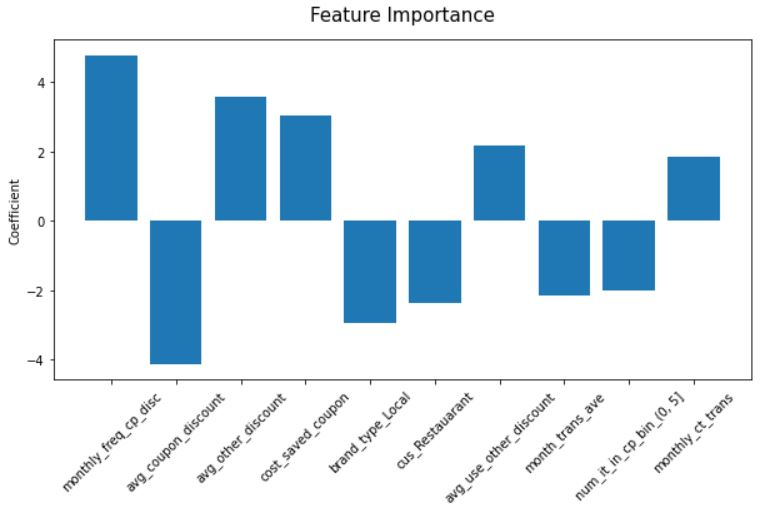

Preliminary results:
1. Customers exhibiting certain purchase behavior (e.g., high monthly frequency of using coupon discount, tendency to purchase larger quantity of goods, and tendency to use other discount) are more likely going to utilize promotions.
2. Restaurants promotions are not effective through coupon campaigns.
3. Coupons that only contain local goods are less likely to be used. It's possible that local goods are generally cheaper than established brands, so the coupons promoting established brands get deemed more often.
4. If a coupon only contains a few items, it is less likely to be utilized.

**5. What is the most challenging part in the project? How did you solve it? How will you futher improve your model if you get more resources and time.**

Two challenges are worth highlighting. One is feature engineering from a large transaction dataset. The other is that the data is extremely imbalanced.

To address the first challenge, I work closely with team members (DAs and DSs) to create a large number of features for evaluation and downselection. This process is iterative and was done effectively by weekly meetings and instant messages. For the second challenge, I applied several techniques known to handle imbalanced data, such as resampling the data, modifying the objective function, and investigating different metrics. 


To further improve the model, I would like to work with the business colleagues and data engineers to see if we can get more customer related features. That should help us further understand our customers, making more complete customer profile. I also hope to test some other techniques to handle imbalanced data, such as using bagging algorithms. 

**Test dataset prediction and submission**

In [184]:
# Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.  

y_test_score = lg2.predict_proba(X_test_scaled)[:,1]

test['redemption_status'] = y_test_score # probability
prediction_submission = test[['id','redemption_status']]

#prediction_submission.to_csv(r'.\prediction_submission.csv')

NameError: name 'lg2' is not defined